In [ ]:
# Jupyter notebook in Jupytext format

## Feature Selection Method Comparison Analysis

This notebook performs comprehensive analysis comparing 3 different feature selection methods:
1. **Network only (distance 3)** - Uses only network features within distance 3
2. **MRMR only** - Applies MRMR to all available features
3. **MRMR + Network (distance 3)** - Original method: network features followed by MRMR filtering

**Note**: The "Clinical + Network" method was removed from analysis since clinical features are a subset of network features (distance 3), making the "Clinical + Network" method effectively equivalent to "Network only".

Each method is evaluated using both SHAP and MDI importance methods, resulting in 6 total conditions.
Analysis includes model performance, stability, feature importance, and comprehensive visual comparisons.

## Initialisation

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [3]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [4]:
# Use the actual directory where results are stored
folder_name = "ThesisResult-FeatureImportanceConsensus"
exp_id = "v1_rf_k500_3methods_split0.3_comparison"

# The results are already in the main folder, no need to create subfolders
main_results_folder = f"{path_loader.get_data_path()}data/results/{folder_name}/"
file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/"

In [5]:
# Load saved feature selection comparison data
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu, kruskal
import warnings
warnings.filterwarnings('ignore')

# Create a new report file for capturing print statements
print_report_path = f"{file_save_path}feature_selection_comparison_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

# Write header to the print report
print_report_file.write(f"# Feature Selection Method Comparison Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("This report captures all print statements from the feature selection method comparison analysis with proper formatting.\n\n")

def save_and_print(message, report_file=None, level="info"):
    """
    Print message to console and save to report file with proper formatting.
    
    Args:
        message: The message to print and save
        report_file: File object to save to (optional)
        level: Formatting level - "header", "section", "subsection", or "info"
    """
    # Print to console
    print(message)
    
    # Save to report with proper formatting
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:  # info level
            report_file.write(f"{message}\n\n")
    
    return message

## Data Loading and Preparation

In [9]:
save_and_print("## Data Loading and Preparation", print_report_file, level="section")

# Define experiment parameters based on the feature_importance_consensus_comparison.py structure
model_name = "RandomForestRegressor"
k_value = 500
split_size = 0.3
network_distance = 3

# Define the 3 feature selection methods (Clinical + Network removed since clinical features are subset of network)
methods = {
    "network_only_d3": "Network only (distance 3)", 
    "mrmr_only": "MRMR only",
    "mrmr_network_d3": "MRMR + Network (distance 3)"
}

# Define all conditions (3 methods × 2 importance methods)
conditions = []
for method_name, method_desc in methods.items():
    conditions.append(f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap")
    conditions.append(f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi")

save_and_print(f"Analyzing {len(conditions)} conditions:", print_report_file, level="info")
for method_name, method_desc in methods.items():
    save_and_print(f"- {method_desc}: SHAP and MDI importance methods", print_report_file, level="info")

## Data Loading and Preparation
Analyzing 6 conditions:
- Network only (distance 3): SHAP and MDI importance methods
- MRMR only: SHAP and MDI importance methods
- MRMR + Network (distance 3): SHAP and MDI importance methods


In [10]:
# Load all available data files from the comparison results folder
data_files = {}

# The main folder where feature selection comparison results are stored
main_results_folder = f"{path_loader.get_data_path()}data/results/{folder_name}/"

save_and_print("### Data Loading Progress", print_report_file, level="subsection")

for condition in conditions:
    condition_data = {}
    
    # Try to load each file type with fallback options
    file_types = [
        f"total_results_{condition}.pkl",
        f"meta_results_{condition}.pkl", 
        f"consensus_feature_importance_{condition}.pkl",
        f"iteration_feature_importance_{condition}.pkl",
        f"consensus_feature_importance_signed_{condition}.pkl",
        f"iteration_feature_importance_signed_{condition}.pkl"
    ]
    
    for file_type in file_types:
        file_path = f"{main_results_folder}{file_type}"
        if os.path.exists(file_path):
            try:
                condition_data[file_type.replace(f"_{condition}.pkl", "")] = pd.read_pickle(file_path)
                save_and_print(f"✓ Loaded {file_type}", print_report_file, level="info")
            except Exception as e:
                save_and_print(f"✗ Failed to load {file_type}: {e}", print_report_file, level="info")
        else:
            save_and_print(f"✗ File not found: {file_type}", print_report_file, level="info")
    
    data_files[condition] = condition_data

# Load comparison and overlap analysis files
comparison_files = [
    f"feature_selection_method_comparison_k{k_value}_split{split_size}.pkl",
    f"feature_set_overlap_analysis_k{k_value}_split{split_size}.pkl"
]

comparison_data = {}
for file_name in comparison_files:
    file_path = f"{main_results_folder}{file_name}"
    if os.path.exists(file_path):
        try:
            comparison_data[file_name] = pd.read_pickle(file_path)
            save_and_print(f"✓ Loaded comparison file: {file_name}", print_report_file, level="info")
        except Exception as e:
            save_and_print(f"✗ Failed to load {file_name}: {e}", print_report_file, level="info")
    else:
        save_and_print(f"✗ Comparison file not found: {file_name}", print_report_file, level="info")

### Data Loading Progress
✓ Loaded total_results_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded iteration_feature_importance_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded consensus_feature_importance_signed_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded iteration_feature_importance_signed_RandomForestRegressor_k500_network_only_d3_split0.3_shap.pkl
✓ Loaded total_results_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✓ Loaded iteration_feature_importance_RandomForestRegressor_k500_network_only_d3_split0.3_mdi.pkl
✗ File not found: consensus_feature_

In [11]:
# Display available data summary
save_and_print("### Available Data Summary", print_report_file, level="subsection")

method_summary = {}
for condition, files in data_files.items():
    # Extract method name from condition
    method_name = '_'.join(condition.split('_')[2:-2])
    importance_method = condition.split('_')[-1]
    
    if method_name not in method_summary:
        method_summary[method_name] = {'shap': 0, 'mdi': 0, 'total_files': 0}
    
    method_summary[method_name][importance_method] += 1
    method_summary[method_name]['total_files'] += len([f for f in files.values() if f is not None])

save_and_print("**Method Data Availability:**", print_report_file, level="info")
for method_name, counts in method_summary.items():
    save_and_print(f"- {methods[method_name]}: SHAP={counts['shap']}, MDI={counts['mdi']}, Total files={counts['total_files']}", 
                  print_report_file, level="info")

### Available Data Summary
**Method Data Availability:**
- Network only (distance 3): SHAP=1, MDI=1, Total files=10
- MRMR only: SHAP=1, MDI=1, Total files=10
- MRMR + Network (distance 3): SHAP=1, MDI=1, Total files=10


## Model Performance Comparison

In [15]:
save_and_print("## Model Performance Comparison", print_report_file, level="section")

def extract_model_performance(data_files):
    """
    Extract model performance metrics from total results files
    """
    performance_data = []
    
    for condition, files in data_files.items():
        if 'total_results' not in files or files['total_results'] is None:
            continue
            
        total_df = files['total_results']
        
        # Extract method information
        parts = condition.split('_')
        method_name = '_'.join(parts[2:-2])
        importance_method = parts[-1]
        
        # Calculate average performance metrics across iterations
        if len(total_df) > 0:
            avg_r2 = total_df['model_performance'].mean()
            std_r2 = total_df['model_performance'].std()
            
            # Extract other metrics if available
            metrics_available = 'metrics' in total_df.columns and len(total_df) > 0
            if metrics_available:
                # Calculate average metrics across iterations
                all_metrics = []
                for metrics_dict in total_df['metrics']:
                    if isinstance(metrics_dict, dict):
                        all_metrics.append(metrics_dict)
                
                if all_metrics:
                    metrics_df = pd.DataFrame(all_metrics)
                    avg_metrics = metrics_df.mean()
                    std_metrics = metrics_df.std()
                else:
                    avg_metrics = pd.Series({'r2': avg_r2, 'pearson_r': np.nan, 'spearman_rho': np.nan})
                    std_metrics = pd.Series({'r2': std_r2, 'pearson_r': np.nan, 'spearman_rho': np.nan})
            else:
                avg_metrics = pd.Series({'r2': avg_r2, 'pearson_r': np.nan, 'spearman_rho': np.nan})
                std_metrics = pd.Series({'r2': std_r2, 'pearson_r': np.nan, 'spearman_rho': np.nan})
            
            performance_data.append({
                'condition': condition,
                'method': method_name,
                'method_description': methods[method_name],
                'importance_method': importance_method,
                'avg_r2': avg_metrics.get('r2', avg_r2),
                'std_r2': std_metrics.get('r2', std_r2),
                'avg_pearson_r': avg_metrics.get('pearson_r', np.nan),
                'std_pearson_r': std_metrics.get('pearson_r', np.nan),
                'avg_spearman_rho': avg_metrics.get('spearman_rho', np.nan),
                'std_spearman_rho': std_metrics.get('spearman_rho', np.nan),
                'n_iterations': len(total_df)
            })
    
    return pd.DataFrame(performance_data)

# Extract performance data
performance_df = extract_model_performance(data_files)

if len(performance_df) > 0:
    save_and_print("### Model Performance Summary", print_report_file, level="subsection")
    save_and_print(performance_df.to_string(index=False), print_report_file, level="info")
else:
    save_and_print("No performance data available", print_report_file, level="info")

## Model Performance Comparison
### Model Performance Summary
                                               condition          method          method_description importance_method   avg_r2   std_r2  avg_pearson_r  std_pearson_r  avg_spearman_rho  std_spearman_rho  n_iterations
RandomForestRegressor_k500_network_only_d3_split0.3_shap network_only_d3   Network only (distance 3)              shap 0.373582 0.040299       0.620020       0.036363          0.576680          0.041530            58
 RandomForestRegressor_k500_network_only_d3_split0.3_mdi network_only_d3   Network only (distance 3)               mdi 0.376746 0.049381       0.621753       0.041452          0.578103          0.045173            55
      RandomForestRegressor_k500_mrmr_only_split0.3_shap       mrmr_only                   MRMR only              shap 0.381495 0.037827       0.623267       0.030374          0.584534          0.036131            42
       RandomForestRegressor_k500_mrmr_only_split0.3_mdi       mrmr_on

### Performance Visualization

In [16]:
# Set publication-quality plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create consistent color mapping for methods
method_colors = {
    'network_only_d3': '#ff7f0e',      # Orange
    'mrmr_only': '#2ca02c',            # Green
    'mrmr_network_d3': '#d62728'       # Red
}

importance_method_markers = {
    'shap': 'o',
    'mdi': 's'
}

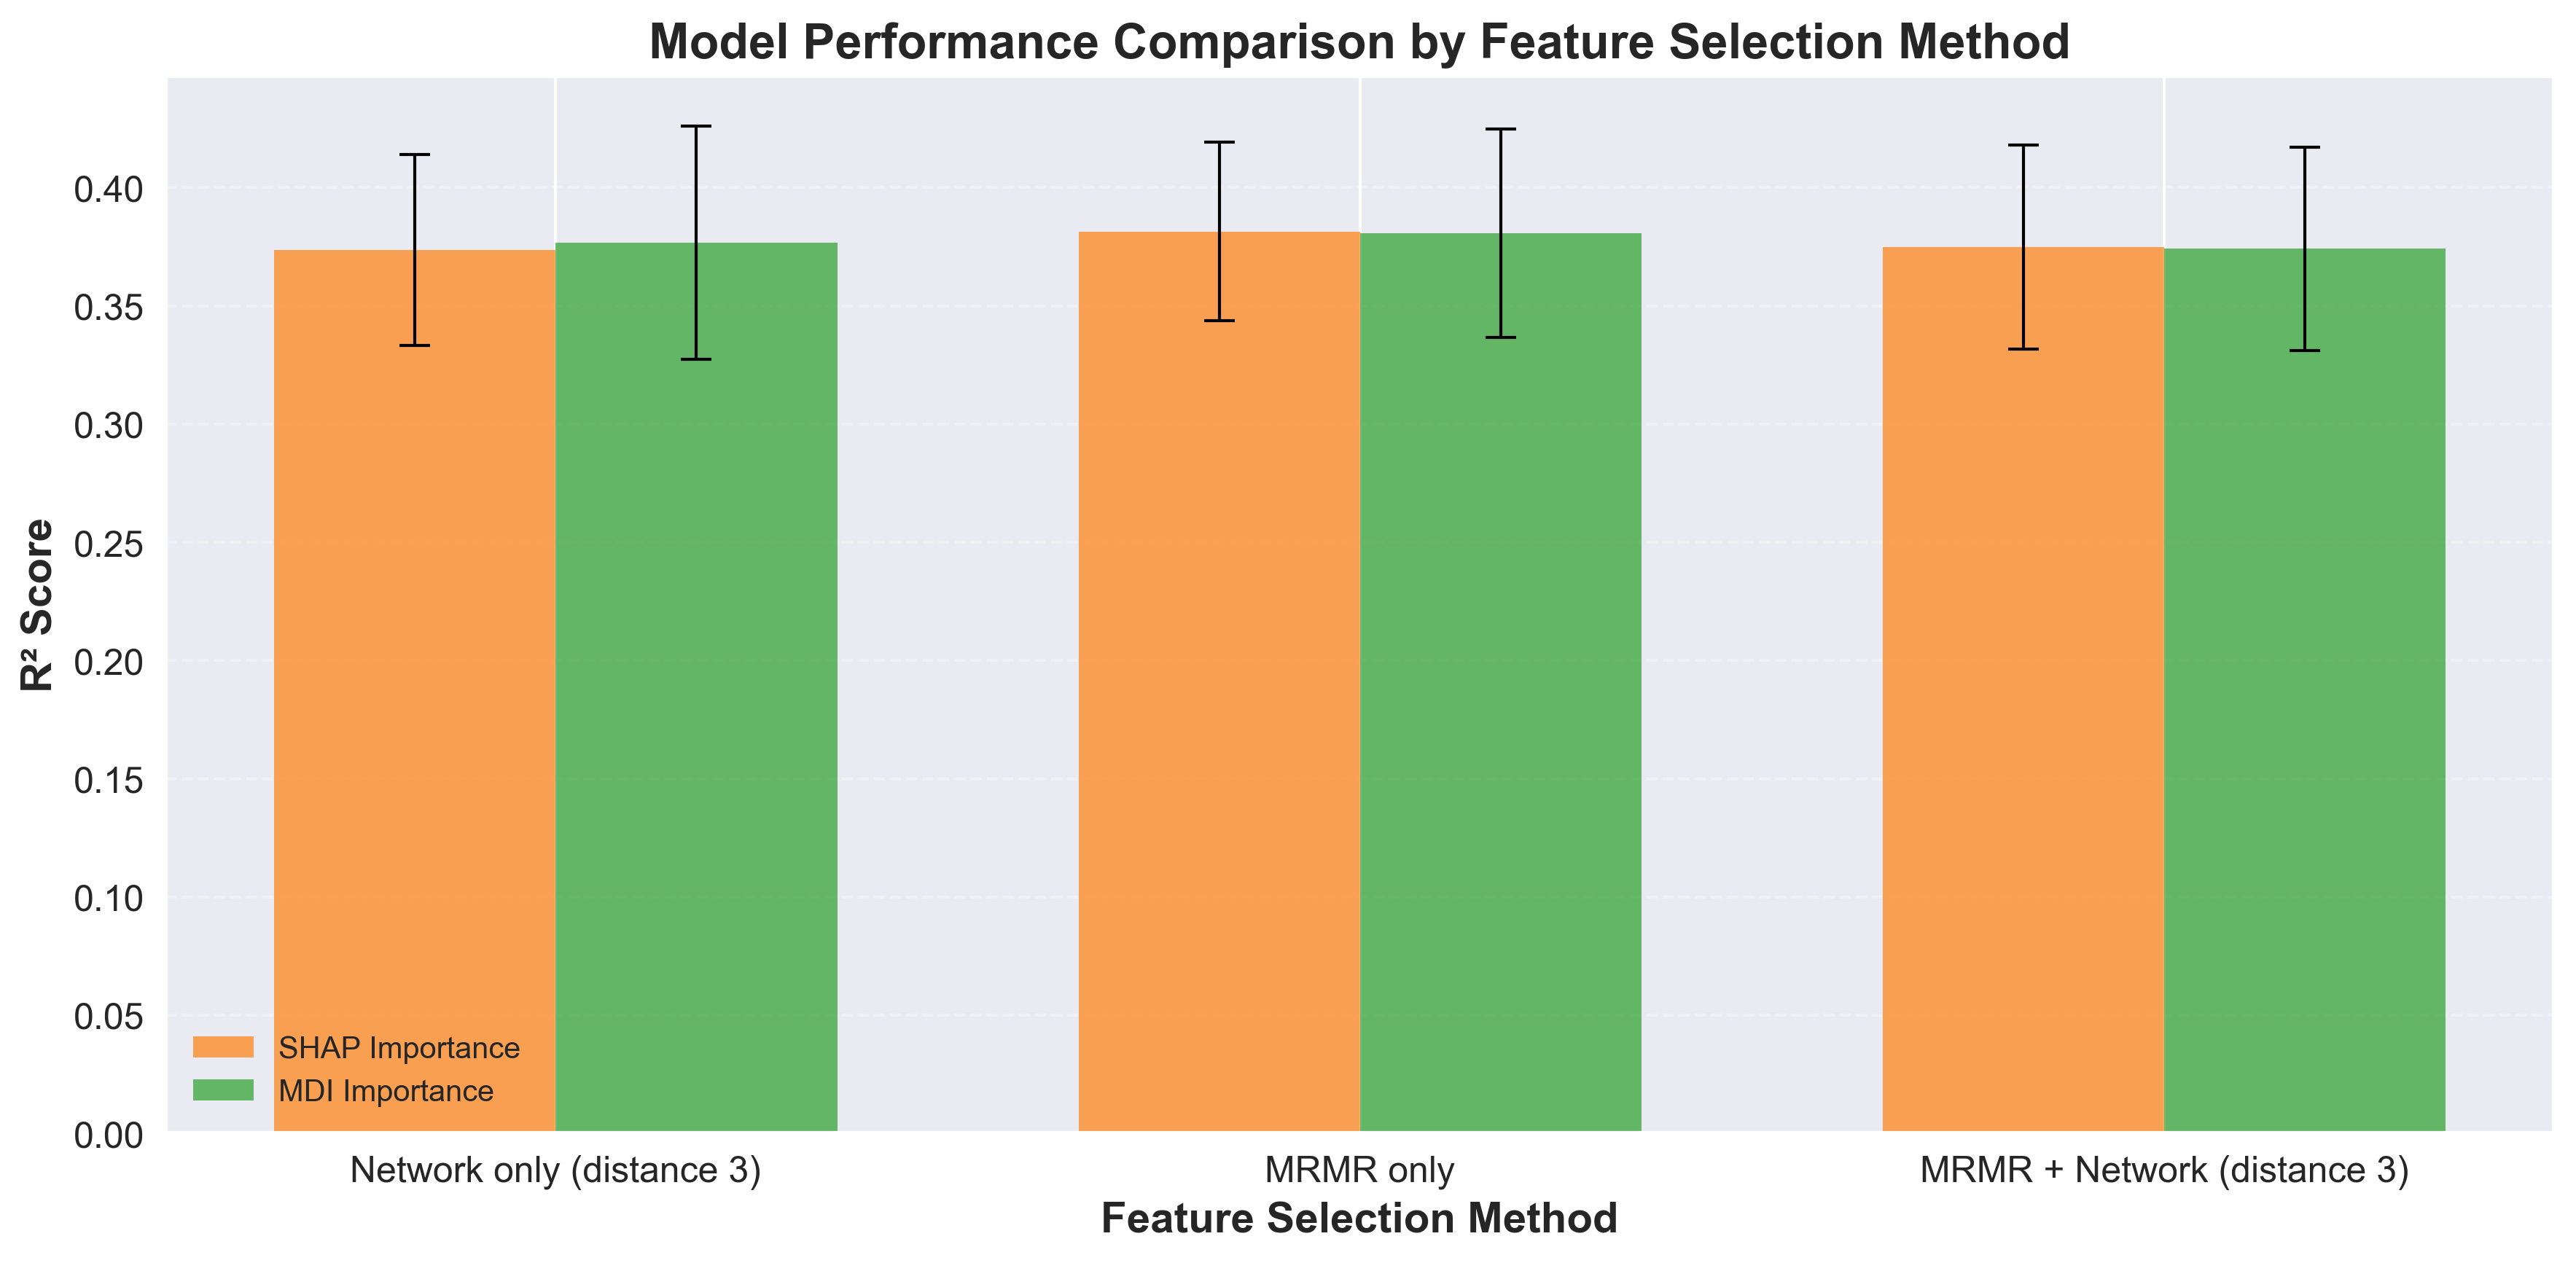

Created model performance comparison bar chart


In [17]:
if len(performance_df) > 0:
    # Plot 1: R² performance comparison - Bar chart version
    plt.figure(figsize=(12, 6), dpi=300)
    
    # Prepare data for bar chart
    x_pos = np.arange(len(methods))
    width = 0.35
    
    # Create grouped bar chart
    for i, importance_method in enumerate(['shap', 'mdi']):
        method_r2_values = []
        method_std_values = []
        
        for method_name in methods.keys():
            method_data = performance_df[performance_df['method'] == method_name]
            imp_data = method_data[method_data['importance_method'] == importance_method]
            
            if len(imp_data) > 0:
                method_r2_values.append(imp_data['avg_r2'].iloc[0])
                method_std_values.append(imp_data['std_r2'].iloc[0])
            else:
                method_r2_values.append(np.nan)
                method_std_values.append(np.nan)
        
        # Plot bars for this importance method
        bar_positions = x_pos + (width * (i - 0.5))
        bars = plt.bar(bar_positions, method_r2_values, width, 
                      label=f'{importance_method.upper()} Importance',
                      color=['#ff7f0e', '#2ca02c'][i], alpha=0.7)
        
        # Add error bars
        plt.errorbar(bar_positions, method_r2_values, yerr=method_std_values, 
                    fmt='none', ecolor='black', capsize=5, capthick=1, elinewidth=1)
    
    plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.ylabel('R² Score', fontsize=14, fontweight='bold')
    plt.title('Model Performance Comparison by Feature Selection Method', fontsize=16, fontweight='bold')
    plt.xticks(x_pos, [methods[m] for m in methods.keys()], rotation=0)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}model_performance_comparison_bar_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created model performance comparison bar chart", print_report_file, level="info")

### Statistical Comparison of Performance

In [18]:
save_and_print("### Statistical Comparison of Model Performance", print_report_file, level="subsection")

def perform_statistical_comparisons(performance_df):
    """
    Perform statistical comparisons between methods and importance methods
    """
    results = {}
    
    if len(performance_df) < 2:
        return results
    
    # Compare methods within each importance method
    for importance_method in ['shap', 'mdi']:
        imp_data = performance_df[performance_df['importance_method'] == importance_method]
        if len(imp_data) >= 2:
            # Kruskal-Wallis test for method differences
            method_groups = [group['avg_r2'].values for name, group in imp_data.groupby('method')]
            if all(len(group) > 0 for group in method_groups):
                h_stat, p_value = kruskal(*method_groups)
                results[f'methods_{importance_method}'] = {
                    'test': 'Kruskal-Wallis',
                    'statistic': h_stat,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
    
    # Compare importance methods within each method
    for method_name in performance_df['method'].unique():
        method_data = performance_df[performance_df['method'] == method_name]
        if len(method_data) == 2:  # Should have both SHAP and MDI
            shap_data = method_data[method_data['importance_method'] == 'shap']
            mdi_data = method_data[method_data['importance_method'] == 'mdi']
            
            if len(shap_data) > 0 and len(mdi_data) > 0:
                # Mann-Whitney U test
                u_stat, p_value = mannwhitneyu([shap_data['avg_r2'].iloc[0]], [mdi_data['avg_r2'].iloc[0]])
                results[f'importance_{method_name}'] = {
                    'test': 'Mann-Whitney U',
                    'statistic': u_stat,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                }
    
    return results

# Perform statistical comparisons
statistical_results = perform_statistical_comparisons(performance_df)

if statistical_results:
    save_and_print("**Statistical Test Results:**", print_report_file, level="info")
    for test_name, result in statistical_results.items():
        significance = "SIGNIFICANT" if result['significant'] else "not significant"
        save_and_print(f"{test_name}: {result['test']} statistic={result['statistic']:.3f}, p={result['p_value']:.4f} ({significance})", 
                      print_report_file, level="info")
else:
    save_and_print("Insufficient data for statistical comparisons", print_report_file, level="info")

### Statistical Comparison of Model Performance
**Statistical Test Results:**
methods_shap: Kruskal-Wallis statistic=2.000, p=0.3679 (not significant)
methods_mdi: Kruskal-Wallis statistic=2.000, p=0.3679 (not significant)
importance_network_only_d3: Mann-Whitney U statistic=0.000, p=1.0000 (not significant)
importance_mrmr_only: Mann-Whitney U statistic=1.000, p=1.0000 (not significant)
importance_mrmr_network_d3: Mann-Whitney U statistic=1.000, p=1.0000 (not significant)


## Feature Selection Stability Analysis

In [19]:
save_and_print("## Feature Selection Stability Analysis", print_report_file, level="section")

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    if len(set1) == 0 and len(set2) == 0:
        return 1.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def calculate_method_stability(data_files, top_n=50):
    """
    Calculate Jaccard stability for each method - VECTORIZED OPTIMIZATION
    """
    stability_results = {}
    
    for condition, files in data_files.items():
        if 'iteration_feature_importance' not in files or files['iteration_feature_importance'] is None:
            continue
            
        iteration_df = files['iteration_feature_importance']
        
        # Extract method information
        method_name = '_'.join(condition.split('_')[2:-2])
        importance_method = condition.split('_')[-1]
        
        # Get unique iterations
        iterations = iteration_df['iteration_rng'].unique()
        
        if len(iterations) < 2:
            continue
        
        # VECTORIZED OPTIMIZATION: Precompute top features for all iterations at once
        # Group by iteration and get top N features for each
        iteration_groups = iteration_df.groupby('iteration_rng')
        
        # Create a dictionary of top feature sets for each iteration
        top_features_dict = {}
        for iteration, group in iteration_groups:
            top_features = set(group.nlargest(top_n, 'importance_score')['feature_name'])
            top_features_dict[iteration] = top_features
        
        # Convert to arrays for vectorized operations
        iteration_list = list(top_features_dict.keys())
        feature_sets = list(top_features_dict.values())
        
        # Calculate pairwise Jaccard similarities using vectorized approach
        n_iterations = len(iteration_list)
        jaccard_similarities = []
        iteration_pairs = []
        
        # Precompute feature sets as boolean arrays for faster intersection/union
        # Get all unique features across all iterations
        all_features = set()
        for feature_set in feature_sets:
            all_features.update(feature_set)
        all_features = sorted(all_features)  # Sort for consistent indexing
        
        # Create boolean matrix where rows are iterations, columns are features
        feature_matrix = np.zeros((n_iterations, len(all_features)), dtype=bool)
        for i, feature_set in enumerate(feature_sets):
            for j, feature in enumerate(all_features):
                if feature in feature_set:
                    feature_matrix[i, j] = True
        
        # Vectorized Jaccard calculation
        for i in range(n_iterations):
            for j in range(i+1, n_iterations):
                # Vectorized intersection and union
                intersection = np.sum(feature_matrix[i] & feature_matrix[j])
                union = np.sum(feature_matrix[i] | feature_matrix[j])
                
                similarity = intersection / union if union > 0 else 0.0
                jaccard_similarities.append(similarity)
                iteration_pairs.append((iteration_list[i], iteration_list[j]))
        
        if jaccard_similarities:
            key = f"{method_name}_{importance_method}"
            stability_results[key] = {
                'method': method_name,
                'importance_method': importance_method,
                'mean_jaccard': np.mean(jaccard_similarities),
                'std_jaccard': np.std(jaccard_similarities),
                'n_comparisons': len(jaccard_similarities),
                'all_similarities': jaccard_similarities
            }
    
    return stability_results

# Calculate stability for different top N values
top_n_values = [25, 50, 100]
stability_results_all = {}

for top_n in top_n_values:
    stability_results = calculate_method_stability(data_files, top_n)
    stability_results_all[top_n] = stability_results
    
    save_and_print(f"### Jaccard Stability (Top {top_n} Features)", print_report_file, level="subsection")
    for key, results in stability_results.items():
        save_and_print(f"{methods[results['method']]} ({results['importance_method'].upper()}): Mean Jaccard = {results['mean_jaccard']:.3f} ± {results['std_jaccard']:.3f}", 
                      print_report_file, level="info")

## Feature Selection Stability Analysis
### Jaccard Stability (Top 25 Features)
Network only (distance 3) (SHAP): Mean Jaccard = 0.329 ± 0.071
Network only (distance 3) (MDI): Mean Jaccard = 0.352 ± 0.066
MRMR only (SHAP): Mean Jaccard = 0.266 ± 0.061
MRMR only (MDI): Mean Jaccard = 0.261 ± 0.061
MRMR + Network (distance 3) (SHAP): Mean Jaccard = 0.350 ± 0.070
MRMR + Network (distance 3) (MDI): Mean Jaccard = 0.350 ± 0.070
### Jaccard Stability (Top 50 Features)
Network only (distance 3) (SHAP): Mean Jaccard = 0.338 ± 0.045
Network only (distance 3) (MDI): Mean Jaccard = 0.328 ± 0.048
MRMR only (SHAP): Mean Jaccard = 0.268 ± 0.043
MRMR only (MDI): Mean Jaccard = 0.263 ± 0.043
MRMR + Network (distance 3) (SHAP): Mean Jaccard = 0.371 ± 0.050
MRMR + Network (distance 3) (MDI): Mean Jaccard = 0.357 ± 0.051
### Jaccard Stability (Top 100 Features)
Network only (distance 3) (SHAP): Mean Jaccard = 0.317 ± 0.032
Network only (distance 3) (MDI): Mean Jaccard = 0.296 ± 0.032
MRMR only (SHAP): Me

### Stability Visualization

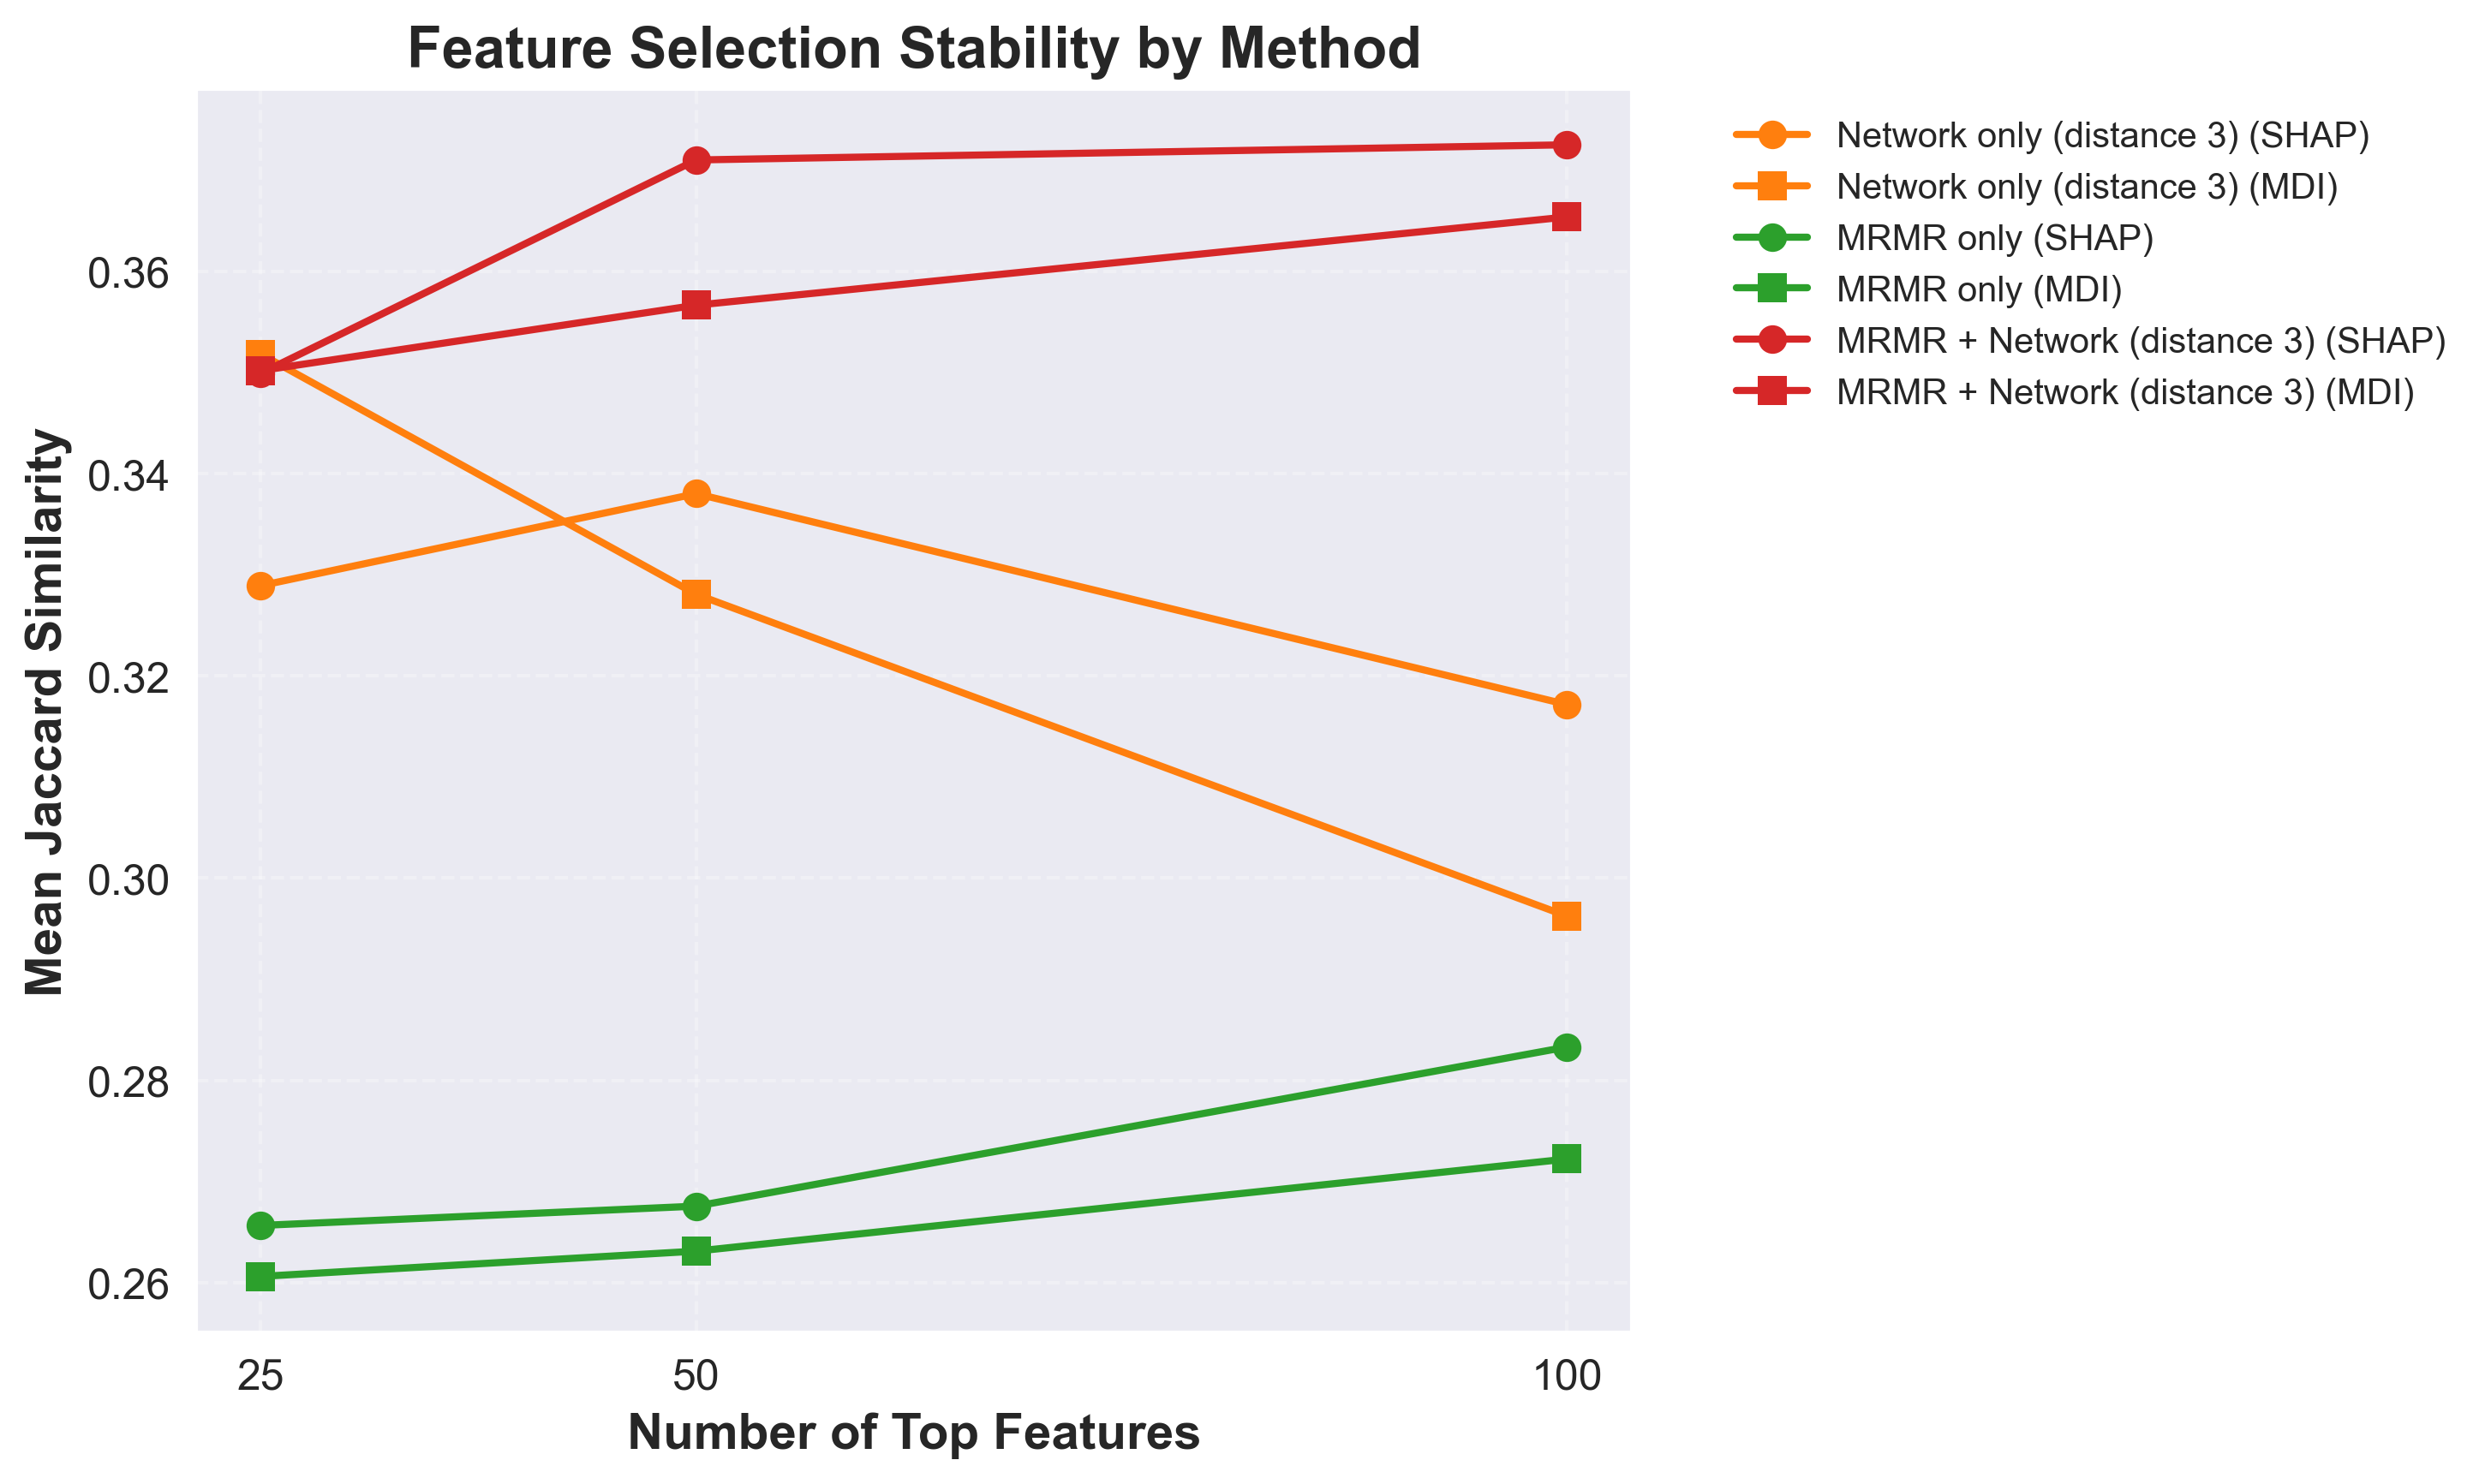

Created stability comparison plot


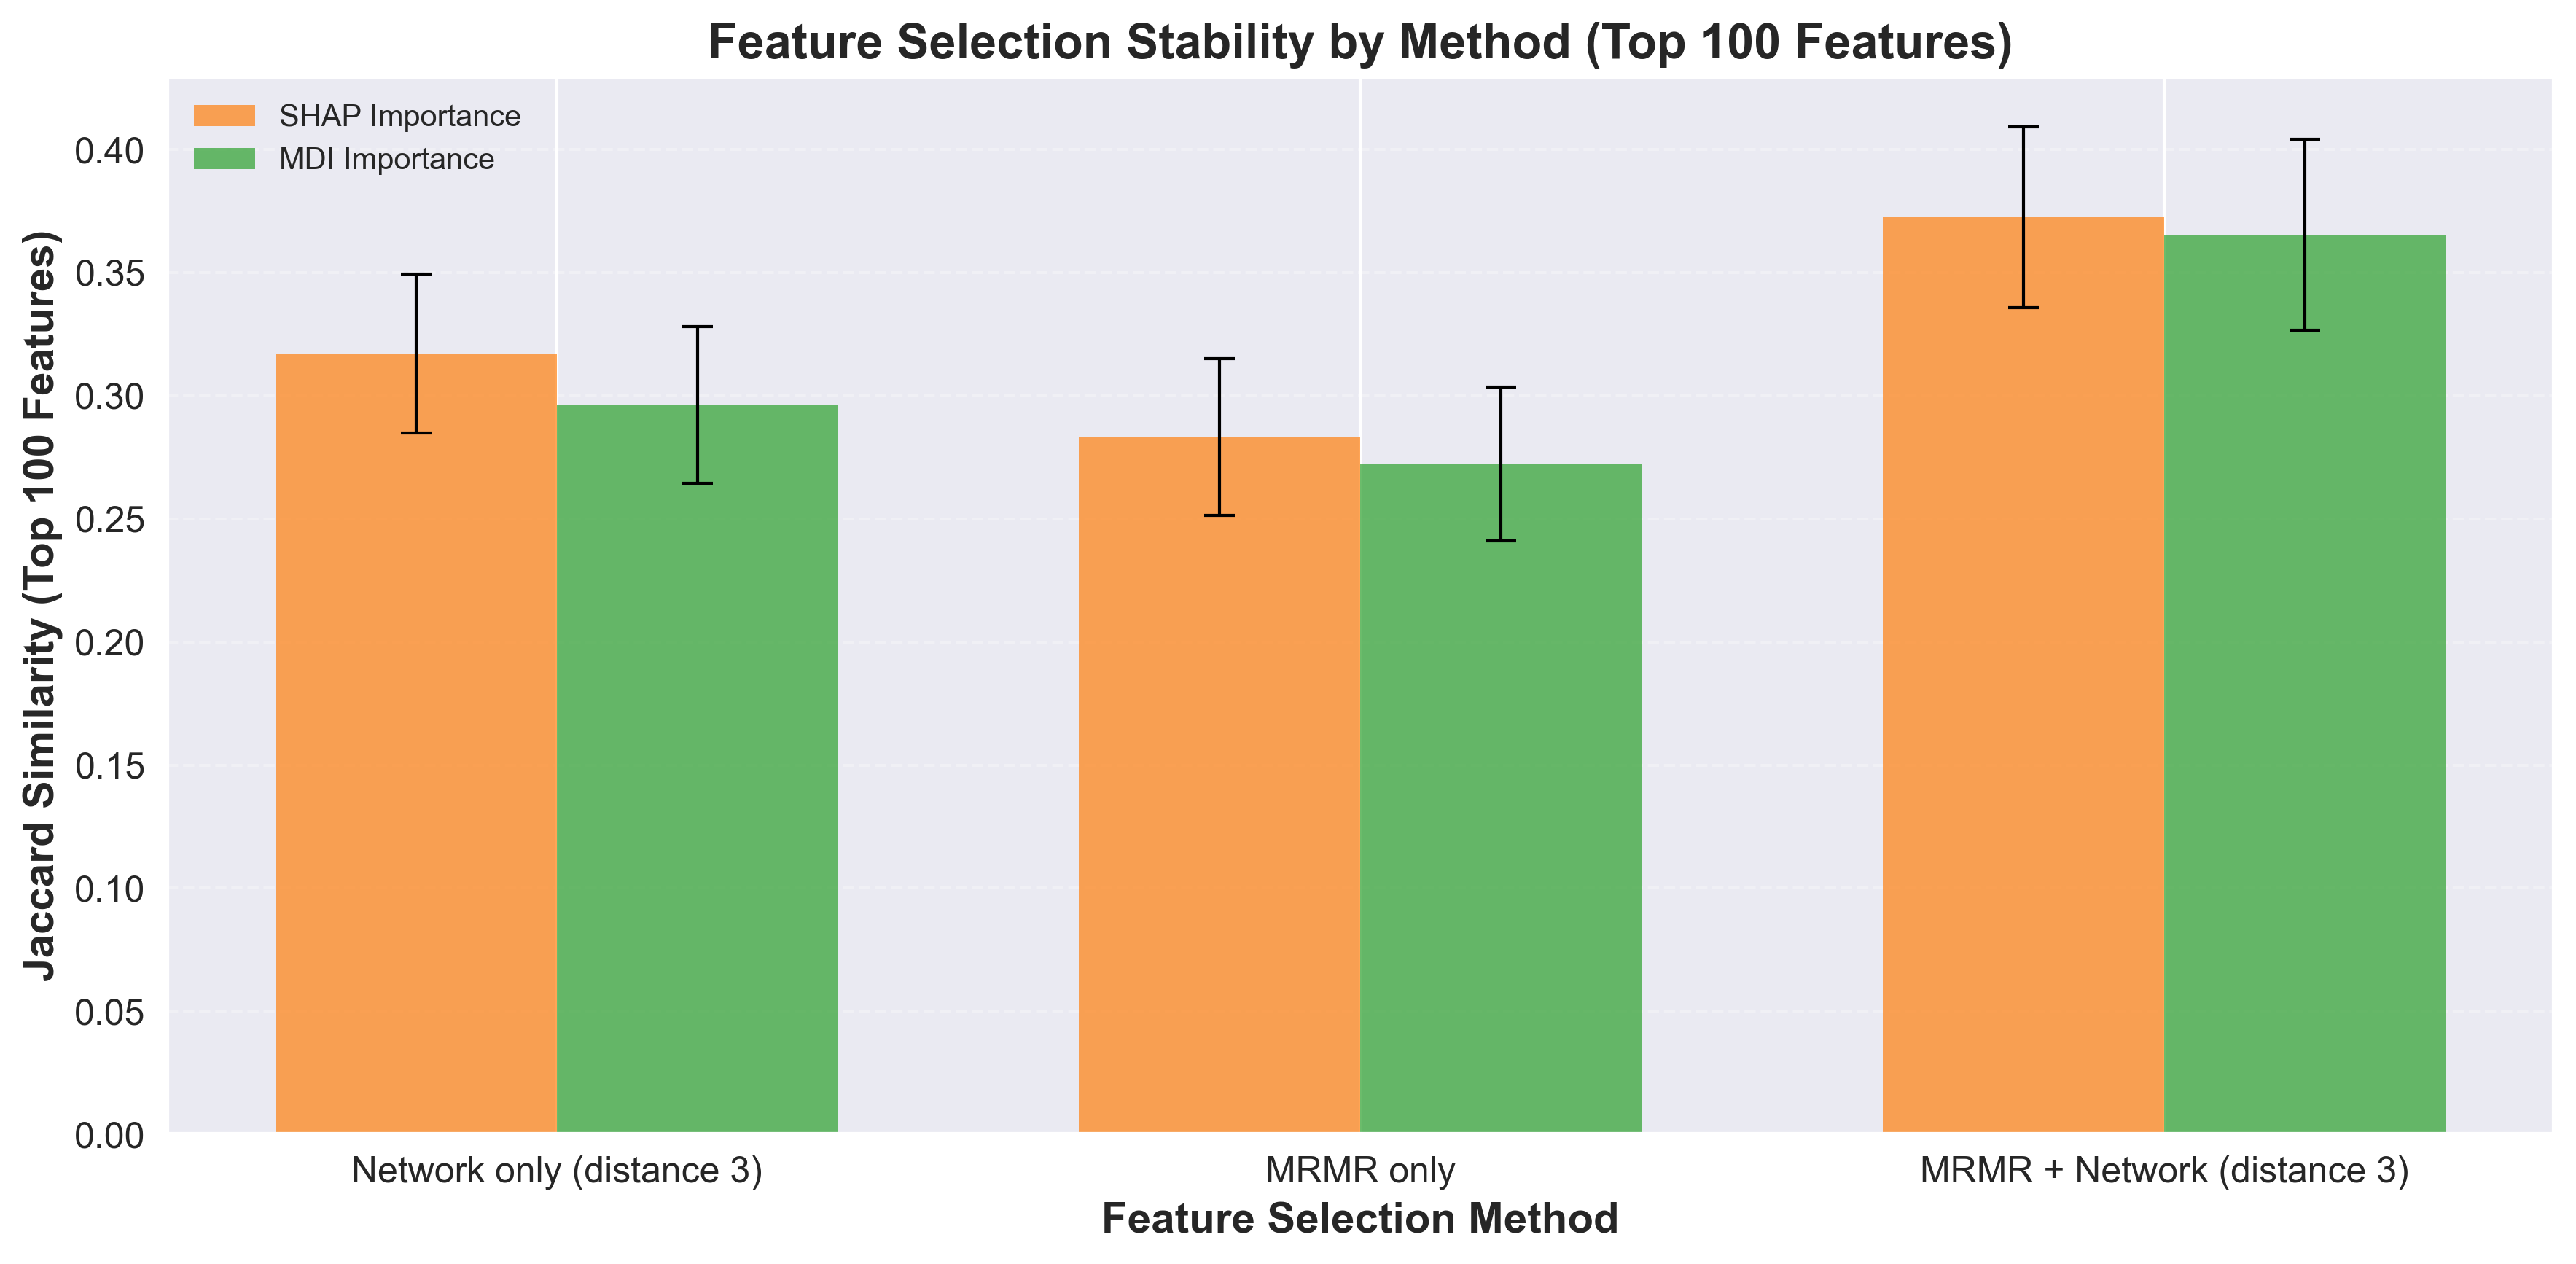

Created stability comparison bar chart for top 100 features


In [20]:
if stability_results_all:
    # Plot stability vs top N features for each method
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Group by method and importance method
    method_stability = {}
    for top_n, results in stability_results_all.items():
        for key, result in results.items():
            method_key = result['method']
            imp_method = result['importance_method']
            full_key = f"{method_key}_{imp_method}"
            
            if full_key not in method_stability:
                method_stability[full_key] = {'top_n': [], 'mean_jaccard': [], 'method': method_key, 'imp_method': imp_method}
            
            method_stability[full_key]['top_n'].append(top_n)
            method_stability[full_key]['mean_jaccard'].append(result['mean_jaccard'])
    
    # Plot each method
    for full_key, data in method_stability.items():
        if len(data['top_n']) > 0:
            color = method_colors[data['method']]
            marker = 'o' if data['imp_method'] == 'shap' else 's'
            label = f"{methods[data['method']]} ({data['imp_method'].upper()})"
            
            plt.plot(data['top_n'], data['mean_jaccard'], marker=marker, color=color, 
                    linewidth=2, markersize=8, label=label)
    
    plt.xlabel('Number of Top Features', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Jaccard Similarity', fontsize=14, fontweight='bold')
    plt.title('Feature Selection Stability by Method', fontsize=16, fontweight='bold')
    plt.xticks(top_n_values)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}stability_comparison_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created stability comparison plot", print_report_file, level="info")
    
    # Create bar chart for stability at top_n=100
    if 100 in stability_results_all:
        plt.figure(figsize=(12, 6), dpi=300)
        
        # Prepare data for bar chart
        x_pos = np.arange(len(methods))
        width = 0.35
        
        # Create grouped bar chart for top_n=100 stability
        for i, importance_method in enumerate(['shap', 'mdi']):
            method_stability_values = []
            method_std_values = []
            
            for method_name in methods.keys():
                key = f"{method_name}_{importance_method}"
                if key in stability_results_all[100]:
                    method_stability_values.append(stability_results_all[100][key]['mean_jaccard'])
                    method_std_values.append(stability_results_all[100][key]['std_jaccard'])
                else:
                    method_stability_values.append(np.nan)
                    method_std_values.append(np.nan)
            
            # Plot bars for this importance method
            bar_positions = x_pos + (width * (i - 0.5))
            bars = plt.bar(bar_positions, method_stability_values, width, 
                          label=f'{importance_method.upper()} Importance',
                          color=['#ff7f0e', '#2ca02c'][i], alpha=0.7)
            
            # Add error bars
            plt.errorbar(bar_positions, method_stability_values, yerr=method_std_values, 
                        fmt='none', ecolor='black', capsize=5, capthick=1, elinewidth=1)
        
        plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
        plt.ylabel('Jaccard Similarity (Top 100 Features)', fontsize=14, fontweight='bold')
        plt.title('Feature Selection Stability by Method (Top 100 Features)', fontsize=16, fontweight='bold')
        plt.xticks(x_pos, [methods[m] for m in methods.keys()])
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y', linestyle='--')
        plt.tight_layout()
        plt.savefig(f"{file_save_path}stability_comparison_top100_bar_{exp_id}.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        save_and_print("Created stability comparison bar chart for top 100 features", print_report_file, level="info")

## Feature Set Overlap Analysis

In [29]:
save_and_print("## Feature Set Overlap Analysis", print_report_file, level="section")

def analyze_feature_set_overlap(data_files, top_n=50):
    """
    Analyze overlap between feature sets selected by different methods
    """
    overlap_results = {}
    
    # Get top features for each method
    method_top_features = {}
    
    for condition, files in data_files.items():
        if 'consensus_feature_importance' not in files or files['consensus_feature_importance'] is None:
            continue
            
        consensus_df = files['consensus_feature_importance']
        method_name = '_'.join(condition.split('_')[2:-2])
        importance_method = condition.split('_')[-1]
        
        key = f"{method_name}_{importance_method}"
        top_features = set(consensus_df.nlargest(top_n, 'mean_importance').index)
        method_top_features[key] = {
            'features': top_features,
            'method': method_name,
            'importance_method': importance_method,
            'n_features': len(top_features)
        }
    
    # Calculate pairwise overlaps
    method_keys = list(method_top_features.keys())
    overlap_data = []
    
    for i in range(len(method_keys)):
        for j in range(i+1, len(method_keys)):
            key1, key2 = method_keys[i], method_keys[j]
            features1 = method_top_features[key1]['features']
            features2 = method_top_features[key2]['features']
            
            intersection = features1 & features2
            union = features1 | features2
            jaccard = len(intersection) / len(union) if len(union) > 0 else 0
            
            overlap_data.append({
                'method_pair': f"{key1} vs {key2}",
                'method1': method_top_features[key1]['method'],
                'method2': method_top_features[key2]['method'],
                'imp_method1': method_top_features[key1]['importance_method'],
                'imp_method2': method_top_features[key2]['importance_method'],
                'intersection': len(intersection),
                'union': len(union),
                'jaccard_similarity': jaccard,
                'overlap_percentage': len(intersection) / top_n * 100
            })
    
    return pd.DataFrame(overlap_data)

# Perform overlap analysis
overlap_df = analyze_feature_set_overlap(data_files, top_n=50)

if len(overlap_df) > 0:
    save_and_print("### Feature Set Overlap Summary (Top 50 Features)", print_report_file, level="subsection")
    save_and_print(overlap_df[['method_pair', 'intersection', 'jaccard_similarity', 'overlap_percentage']].to_string(index=False), 
                  print_report_file, level="info")

## Feature Set Overlap Analysis
### Feature Set Overlap Summary (Top 50 Features)
                                 method_pair  intersection  jaccard_similarity  overlap_percentage
 network_only_d3_shap vs network_only_d3_mdi            44            0.785714                88.0
      network_only_d3_shap vs mrmr_only_shap            16            0.190476                32.0
       network_only_d3_shap vs mrmr_only_mdi            16            0.190476                32.0
network_only_d3_shap vs mrmr_network_d3_shap            42            0.724138                84.0
 network_only_d3_shap vs mrmr_network_d3_mdi            40            0.666667                80.0
       network_only_d3_mdi vs mrmr_only_shap            15            0.176471                30.0
        network_only_d3_mdi vs mrmr_only_mdi            16            0.190476                32.0
 network_only_d3_mdi vs mrmr_network_d3_shap            39            0.639344                78.0
  network_only_d3_mdi vs mr

### Overlap Visualization

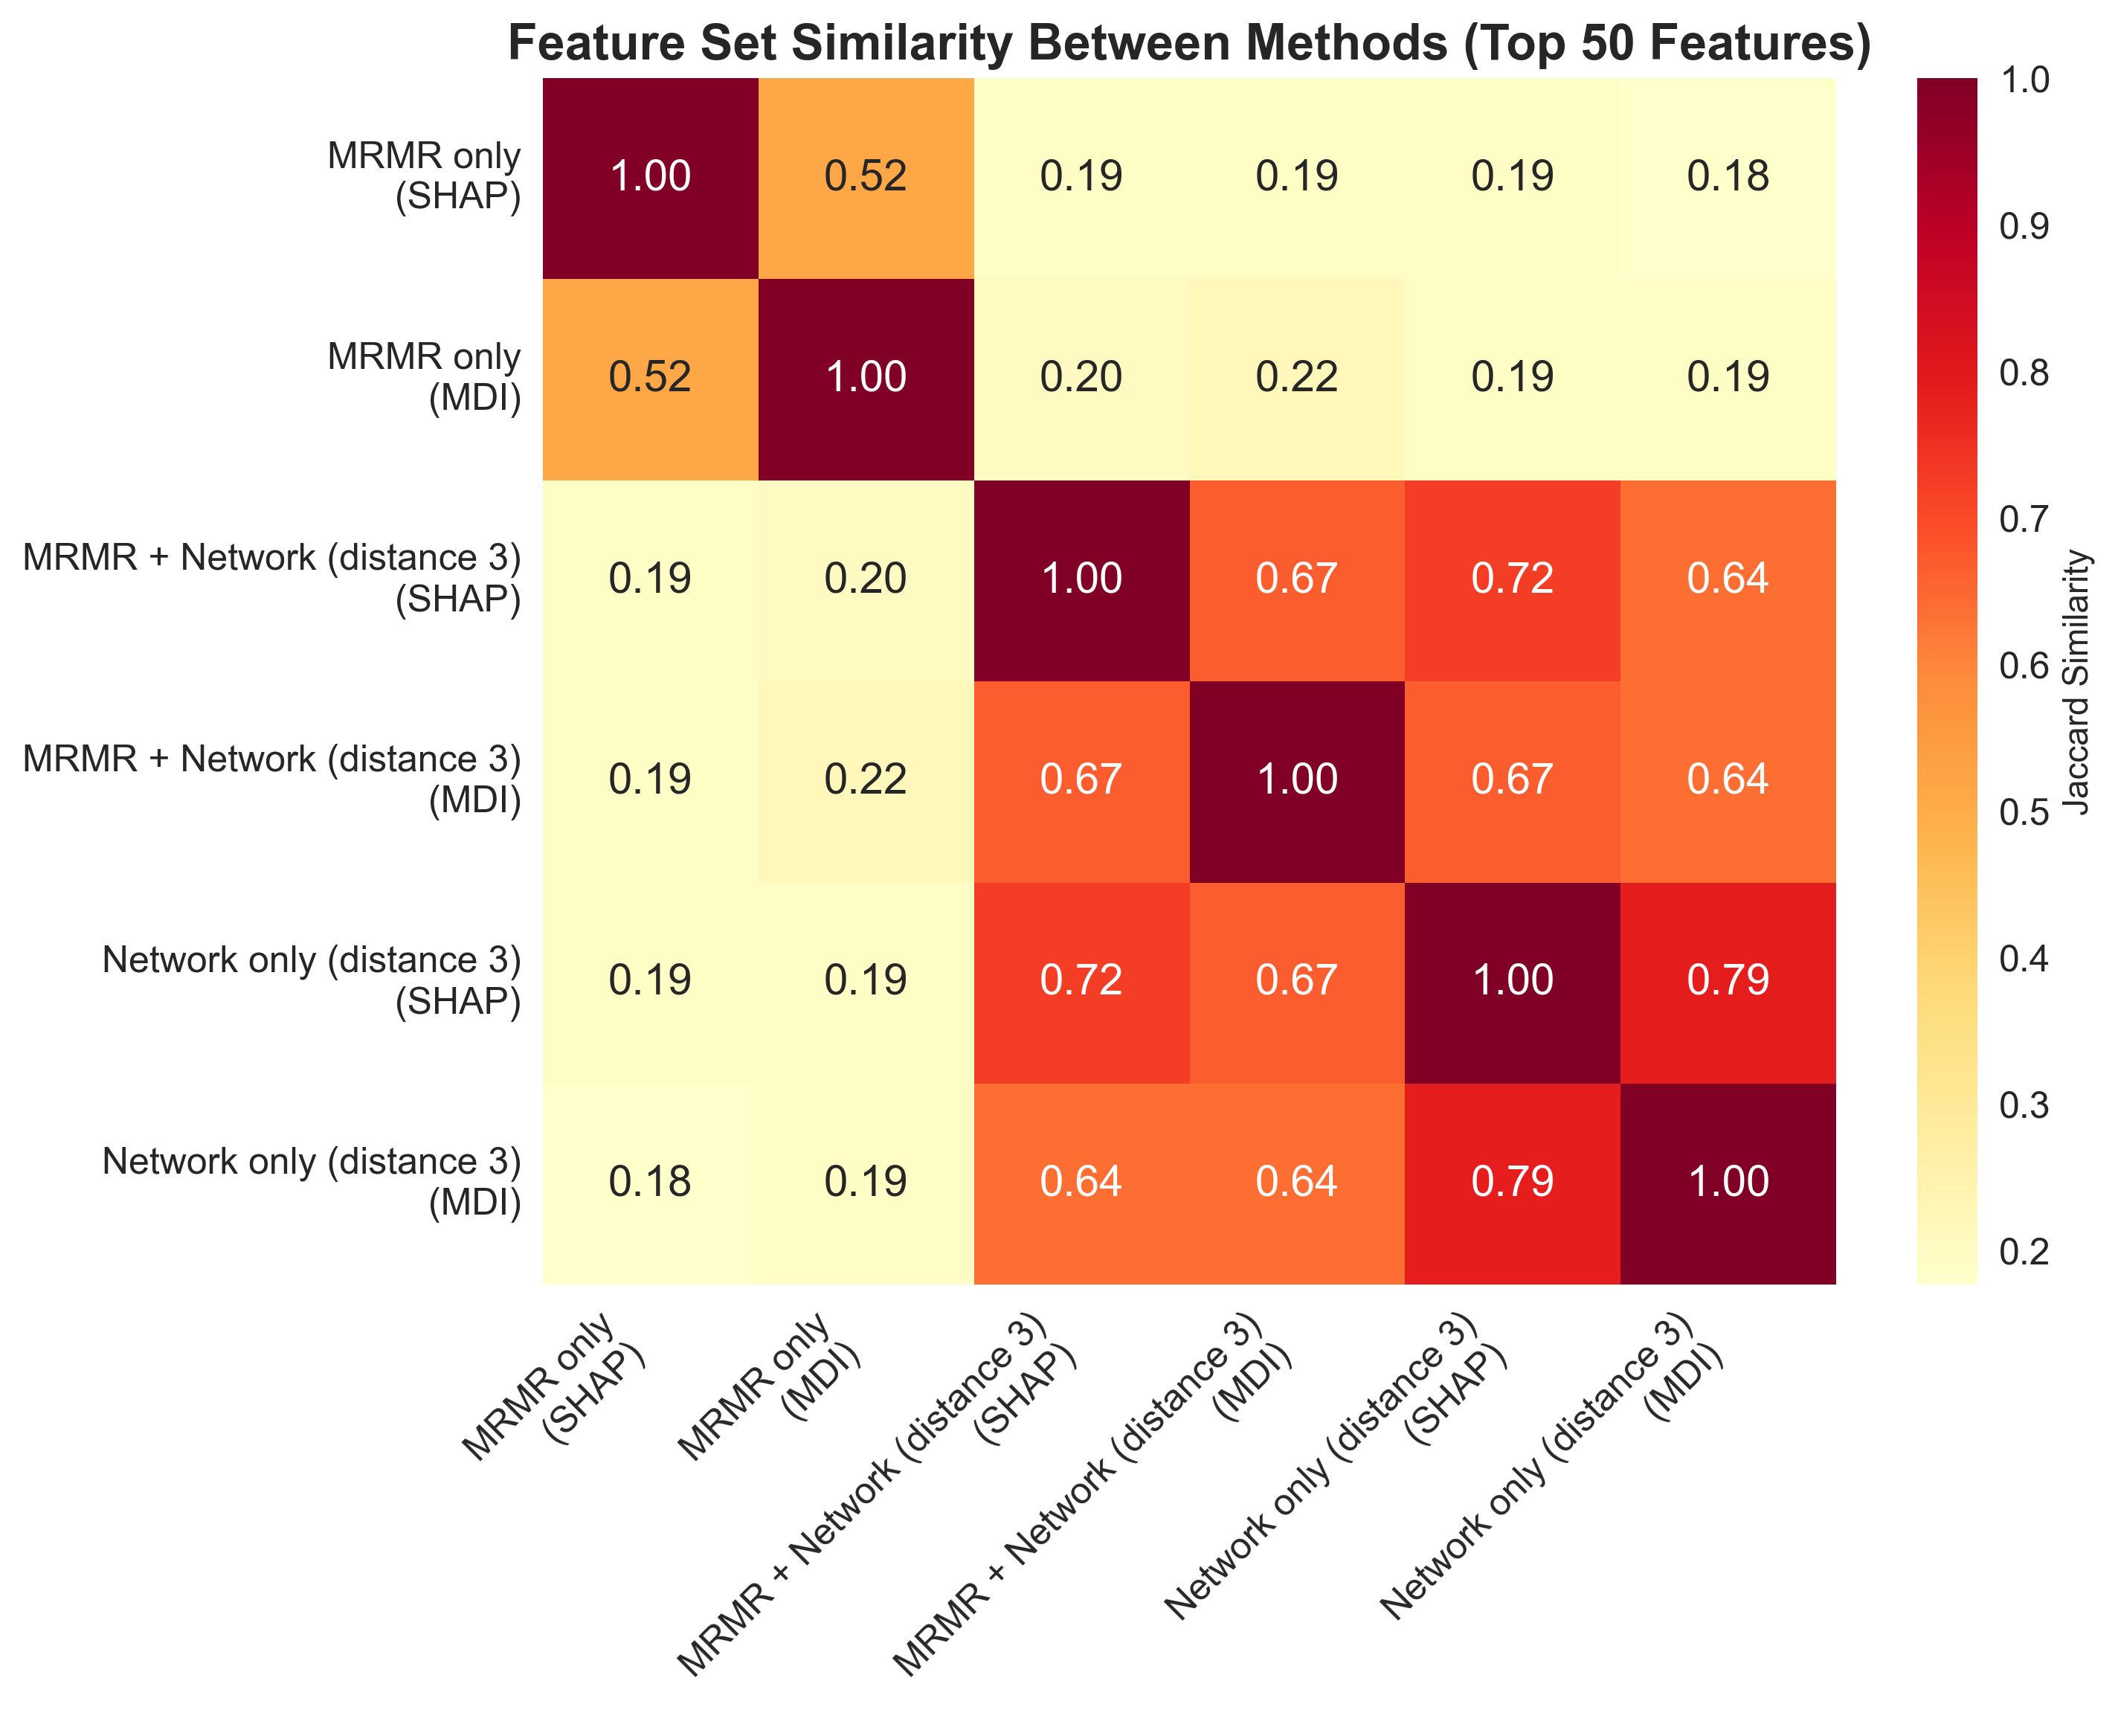

Created feature set similarity heatmap


In [30]:
if len(overlap_df) > 0:
    # Create heatmap of Jaccard similarities
    methods_combined = list(set(overlap_df['method1'].unique()) | set(overlap_df['method2'].unique()))
    imp_methods = ['shap', 'mdi']
    
    # Create matrix for heatmap
    similarity_matrix = np.zeros((len(methods_combined) * 2, len(methods_combined) * 2))
    
    # Fill matrix with Jaccard similarities
    for _, row in overlap_df.iterrows():
        idx1 = methods_combined.index(row['method1']) * 2 + (0 if row['imp_method1'] == 'shap' else 1)
        idx2 = methods_combined.index(row['method2']) * 2 + (0 if row['imp_method2'] == 'shap' else 1)
        similarity_matrix[idx1, idx2] = row['jaccard_similarity']
        similarity_matrix[idx2, idx1] = row['jaccard_similarity']
    
    # Set diagonal to 1 (self-similarity)
    for i in range(len(methods_combined) * 2):
        similarity_matrix[i, i] = 1.0
    
    # Create labels
    labels = []
    for method in methods_combined:
        labels.append(f"{methods[method]}\n(SHAP)")
        labels.append(f"{methods[method]}\n(MDI)")
    
    # Plot heatmap
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='YlOrRd', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Jaccard Similarity'})
    plt.title('Feature Set Similarity Between Methods (Top 50 Features)', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{file_save_path}feature_set_similarity_heatmap_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created feature set similarity heatmap", print_report_file, level="info")

## SHAP Signed Values Analysis by Method

In [37]:
save_and_print("## SHAP Signed Values Analysis by Method", print_report_file, level="section")

def analyze_shap_signed_by_method(data_files):
    """
    Analyze SHAP signed values for each method that used SHAP importance
    """
    shap_results = {}
    
    for condition, files in data_files.items():
        if 'shap' not in condition:
            continue
            
        if 'consensus_feature_importance_signed' not in files or files['consensus_feature_importance_signed'] is None:
            continue
            
        signed_consensus = files['consensus_feature_importance_signed']
        method_name = '_'.join(condition.split('_')[2:-2])
        
        # Analyze directional effects
        positive_effects = signed_consensus[signed_consensus['mean_importance_signed'] > 0]
        negative_effects = signed_consensus[signed_consensus['mean_importance_signed'] < 0]
        
        shap_results[method_name] = {
            'signed_consensus': signed_consensus,
            'positive_effects': positive_effects,
            'negative_effects': negative_effects,
            'total_features': len(signed_consensus),
            'positive_count': len(positive_effects),
            'negative_count': len(negative_effects),
            'positive_ratio': len(positive_effects) / len(signed_consensus) if len(signed_consensus) > 0 else 0
        }
    
    return shap_results

# Perform SHAP analysis by method
shap_by_method = analyze_shap_signed_by_method(data_files)

if shap_by_method:
    save_and_print("### SHAP Signed Values Summary by Method", print_report_file, level="subsection")
    for method_name, results in shap_by_method.items():
        save_and_print(f"**{methods[method_name]}**:", print_report_file, level="info")
        save_and_print(f"  - Total features: {results['total_features']}", print_report_file, level="info")
        save_and_print(f"  - Positive effects: {results['positive_count']} ({results['positive_ratio']:.1%})", print_report_file, level="info")
        save_and_print(f"  - Negative effects: {results['negative_count']}", print_report_file, level="info")

## SHAP Signed Values Analysis by Method
### SHAP Signed Values Summary by Method
**Network only (distance 3)**:
  - Total features: 1280
  - Positive effects: 580 (45.3%)
  - Negative effects: 657
**MRMR only**:
  - Total features: 1230
  - Positive effects: 580 (47.2%)
  - Negative effects: 642
**MRMR + Network (distance 3)**:
  - Total features: 923
  - Positive effects: 437 (47.3%)
  - Negative effects: 474


### SHAP Directional Effects Visualization

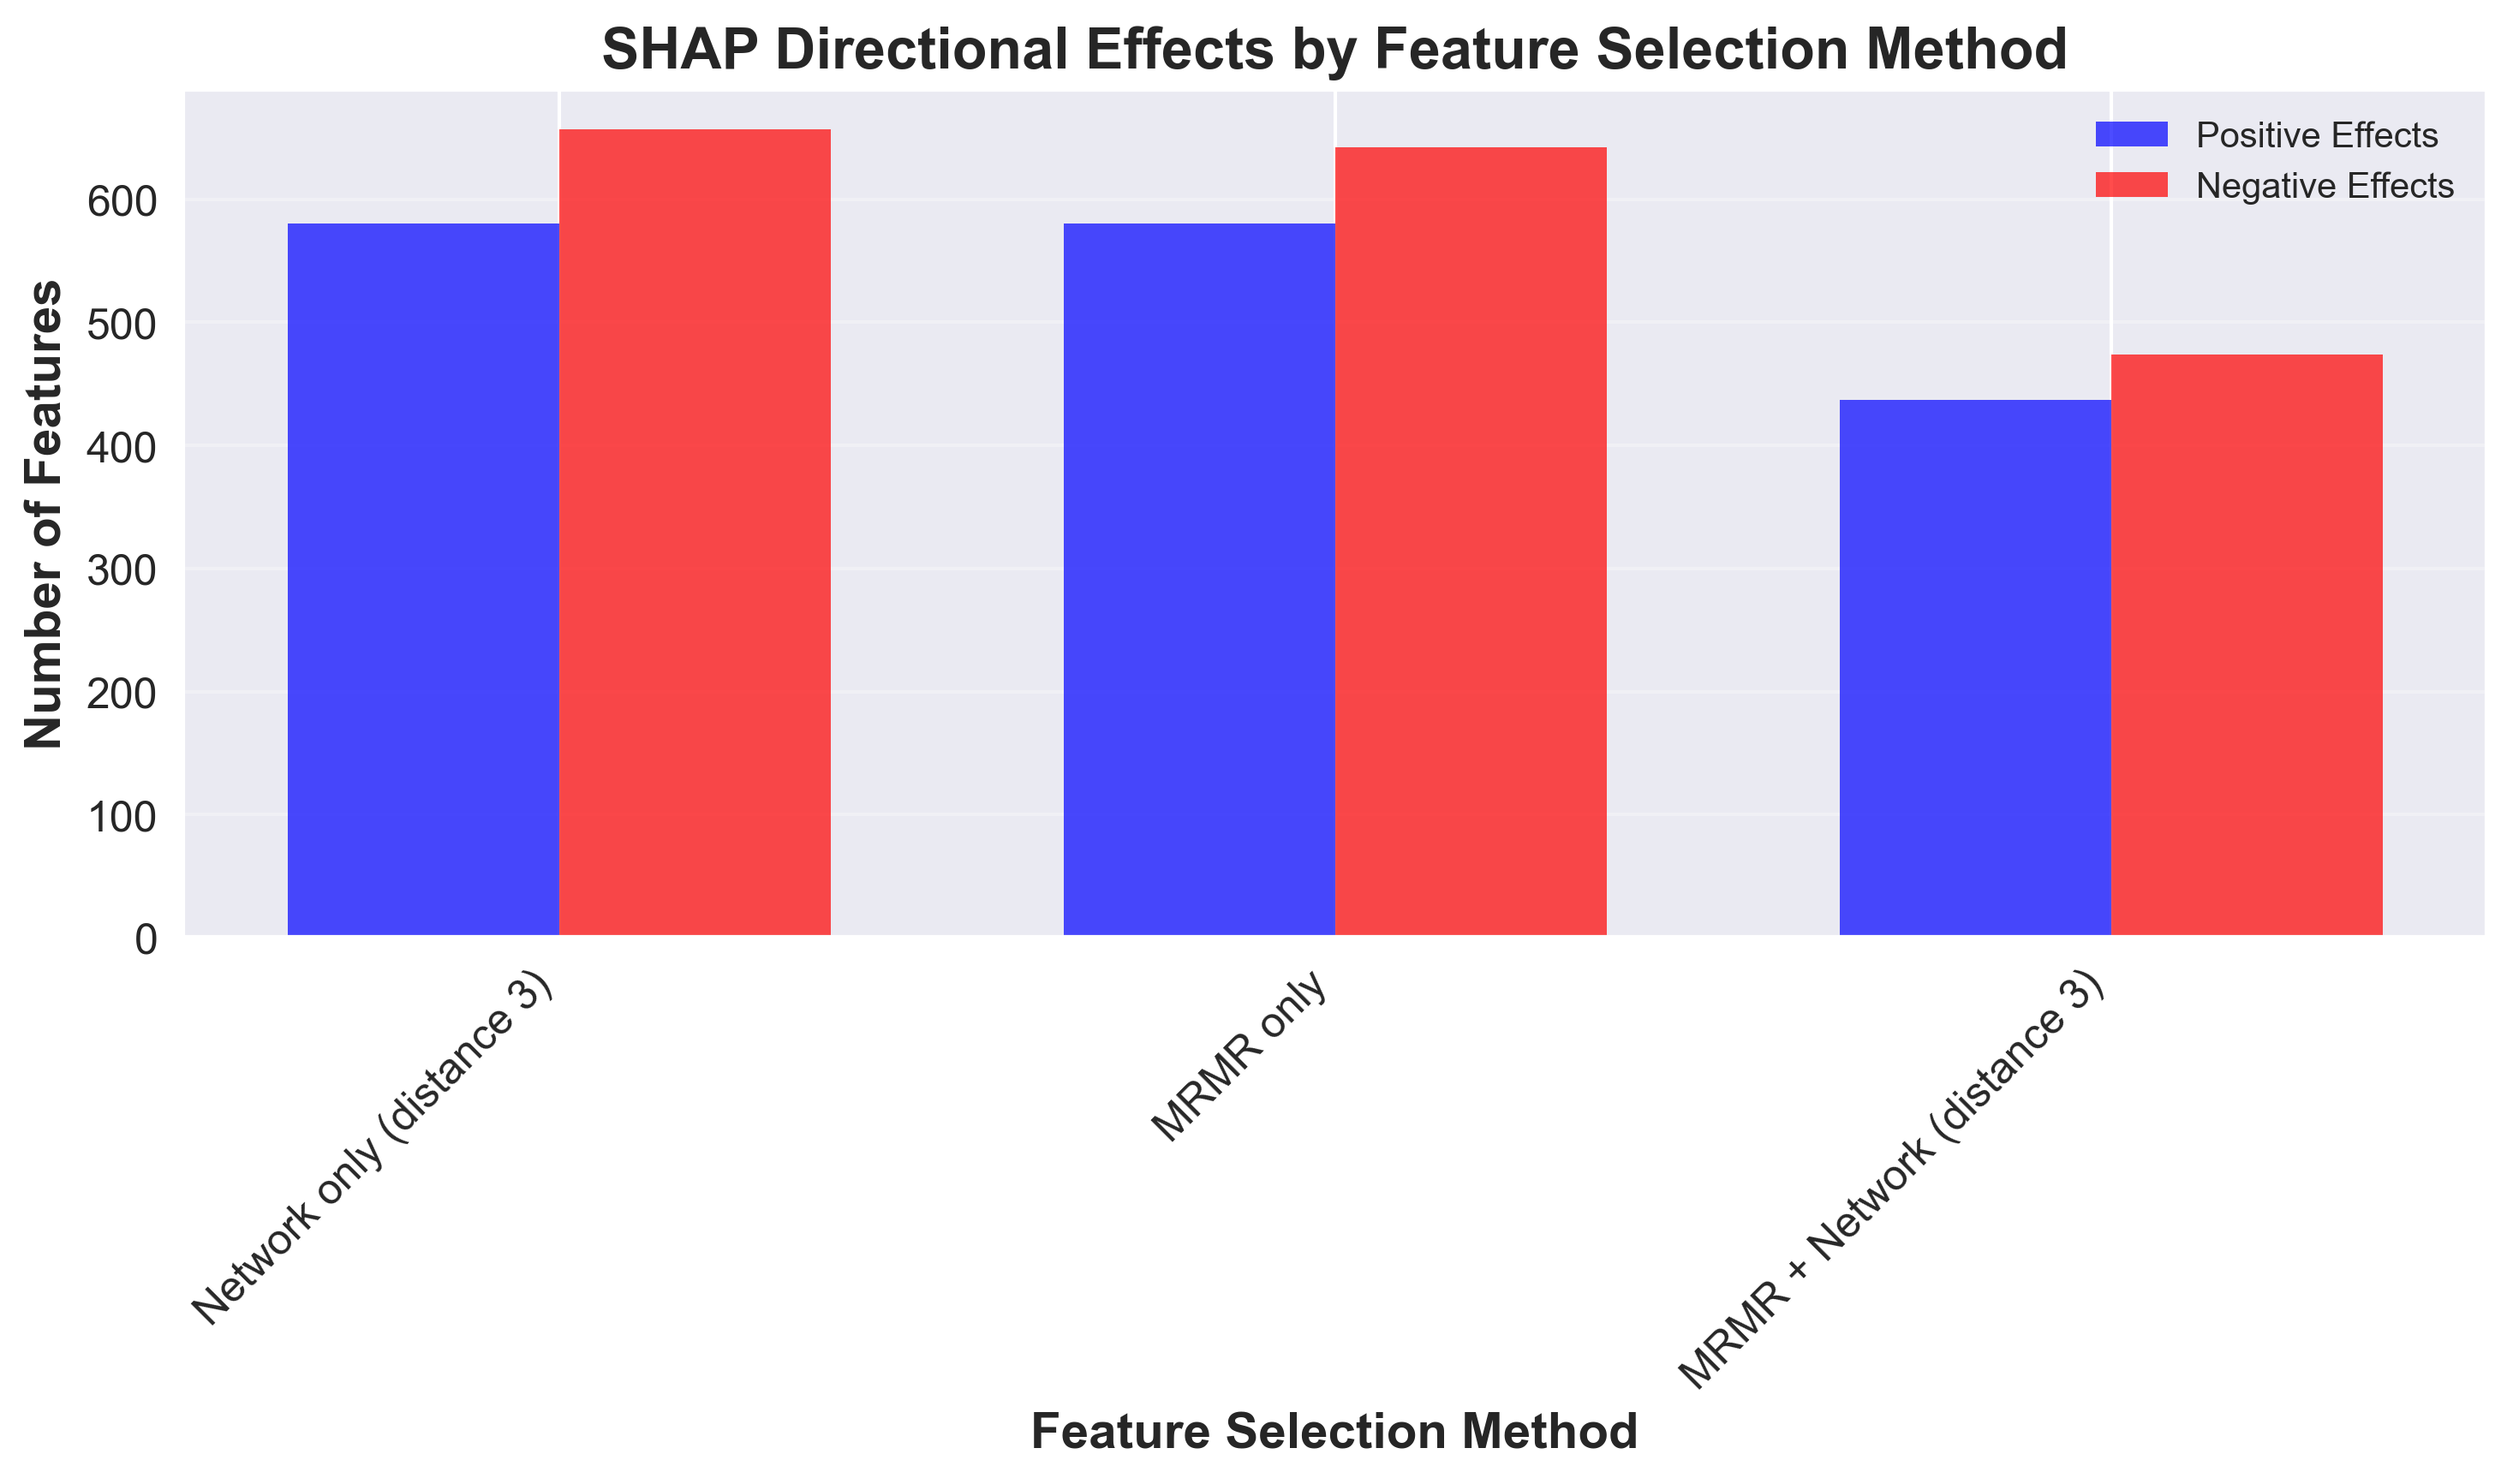

Created SHAP directional effects comparison plot


In [38]:
if shap_by_method:
    # Create comparative bar plot of positive/negative effects
    methods_list = list(shap_by_method.keys())
    positive_counts = [shap_by_method[m]['positive_count'] for m in methods_list]
    negative_counts = [shap_by_method[m]['negative_count'] for m in methods_list]
    total_counts = [shap_by_method[m]['total_features'] for m in methods_list]
    
    x_pos = np.arange(len(methods_list))
    width = 0.35
    
    plt.figure(figsize=(10, 6), dpi=300)
    plt.bar(x_pos - width/2, positive_counts, width, label='Positive Effects', color='blue', alpha=0.7)
    plt.bar(x_pos + width/2, negative_counts, width, label='Negative Effects', color='red', alpha=0.7)
    
    plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Features', fontsize=14, fontweight='bold')
    plt.title('SHAP Directional Effects by Feature Selection Method', fontsize=16, fontweight='bold')
    plt.xticks(x_pos, [methods[m] for m in methods_list], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}shap_directional_effects_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created SHAP directional effects comparison plot", print_report_file, level="info")

## Convergence Analysis

In [ ]:
save_and_print("## Convergence Analysis", print_report_file, level="section")

def analyze_convergence(data_files):
    """
    Analyze convergence characteristics for each method
    """
    convergence_results = {}
    
    for condition, files in data_files.items():
        if 'meta_results' not in files or files['meta_results'] is None:
            continue
            
        meta_df = files['meta_results']
        method_name = '_'.join(condition.split('_')[2:-2])
        importance_method = condition.split('_')[-1]
        
        if len(meta_df) < 2:
            continue
        
        # Calculate convergence metrics
        iterations = meta_df['iteration'].values
        tolerances = meta_df['current_tol'].values
        
        # Normalize for AUC calculation
        normalized_iterations = iterations / iterations.max()
        auc = np.trapz(tolerances, normalized_iterations)
        
        # Convergence rate (slope on log scale)
        if len(tolerances) > 1:
            log_tolerances = np.log(tolerances + 1e-10)
            convergence_rate = np.polyfit(normalized_iterations[:len(log_tolerances)], log_tolerances, 1)[0]
        else:
            convergence_rate = np.nan
        
        key = f"{method_name}_{importance_method}"
        convergence_results[key] = {
            'method': method_name,
            'importance_method': importance_method,
            'auc': auc,
            'convergence_rate': convergence_rate,
            'final_iteration': iterations[-1],
            'final_tolerance': tolerances[-1],
            'n_iterations': len(iterations)
        }
    
    return convergence_results

# Analyze convergence
convergence_results = analyze_convergence(data_files)

if convergence_results:
    save_and_print("### Convergence Metrics Summary", print_report_file, level="subsection")
    convergence_df = pd.DataFrame(convergence_results.values())
    save_and_print(convergence_df.to_string(index=False), print_report_file, level="info")

### Convergence Visualization

In [ ]:
if convergence_results:
    # Plot convergence AUC comparison
    methods_list = list(set([r['method'] for r in convergence_results.values()]))
    auc_data = {method: {'shap': [], 'mdi': []} for method in methods_list}
    
    for key, result in convergence_results.items():
        auc_data[result['method']][result['importance_method']].append(result['auc'])
    
    # Create bar plot
    x_pos = np.arange(len(methods_list))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
    
    # AUC plot
    shap_auc = [np.mean(auc_data[m]['shap']) if auc_data[m]['shap'] else np.nan for m in methods_list]
    mdi_auc = [np.mean(auc_data[m]['mdi']) if auc_data[m]['mdi'] else np.nan for m in methods_list]
    
    bars1 = ax1.bar(x_pos - width/2, shap_auc, width, label='SHAP', color='#ff7f0e', alpha=0.7)
    bars2 = ax1.bar(x_pos + width/2, mdi_auc, width, label='MDI', color='#2ca02c', alpha=0.7)
    
    ax1.set_xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Convergence AUC (Lower = Better)', fontsize=12, fontweight='bold')
    ax1.set_title('Convergence Performance by Method', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([methods[m] for m in methods_list], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Convergence rate plot
    rate_data = {method: {'shap': [], 'mdi': []} for method in methods_list}
    for key, result in convergence_results.items():
        if not np.isnan(result['convergence_rate']):
            rate_data[result['method']][result['importance_method']].append(result['convergence_rate'])
    
    shap_rates = [np.mean(rate_data[m]['shap']) if rate_data[m]['shap'] else np.nan for m in methods_list]
    mdi_rates = [np.mean(rate_data[m]['mdi']) if rate_data[m]['mdi'] else np.nan for m in methods_list]
    
    bars3 = ax2.bar(x_pos - width/2, shap_rates, width, label='SHAP', color='#ff7f0e', alpha=0.7)
    bars4 = ax2.bar(x_pos + width/2, mdi_rates, width, label='MDI', color='#2ca02c', alpha=0.7)
    
    ax2.set_xlabel('Feature Selection Method', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Convergence Rate (More Negative = Faster)', fontsize=12, fontweight='bold')
    ax2.set_title('Convergence Rate by Method', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([methods[m] for m in methods_list], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{file_save_path}convergence_comparison_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created convergence comparison plots", print_report_file, level="info")

## Feature Importance Visualization by Condition

In [ ]:
save_and_print("## Feature Importance Visualization by Condition", print_report_file, level="section")

def create_feature_importance_bar_charts(data_files, top_n=20, save_path=None):
    """
    Create individual bar charts showing feature importance for each condition
    """
    save_and_print("### Individual Condition Feature Importance Charts", print_report_file, level="subsection")
    
    for condition in conditions:
        if 'consensus_feature_importance' not in data_files[condition] or data_files[condition]['consensus_feature_importance'] is None:
            save_and_print(f"Skipping {condition}: No consensus feature importance data", print_report_file, level="info")
            continue
        
        consensus_df = data_files[condition]['consensus_feature_importance']
        
        # Get top N features
        top_features = consensus_df.nlargest(top_n, 'mean_importance')
        
        if len(top_features) == 0:
            save_and_print(f"No features found for {condition}", print_report_file, level="info")
            continue
        
        # Create bar chart
        plt.figure(figsize=(12, 8), dpi=300)
        
        # Extract method and importance method for styling
        method_name = '_'.join(condition.split('_')[2:-2])
        importance_method = condition.split('_')[-1]
        
        # Create bar plot
        bars = plt.barh(range(len(top_features)), top_features['mean_importance'], 
                       color=method_colors[method_name], alpha=0.7)
        
        # Add error bars if available
        if 'std_importance' in top_features.columns:
            plt.errorbar(top_features['mean_importance'], range(len(top_features)),
                        xerr=top_features['std_importance'], fmt='none', 
                        ecolor='black', capsize=3, capthick=1, elinewidth=1)
        
        plt.xlabel('Feature Importance Score', fontsize=14, fontweight='bold')
        plt.ylabel('Features', fontsize=14, fontweight='bold')
        plt.title(f'Top {top_n} Features - {methods[method_name]} ({importance_method.upper()})', 
                 fontsize=16, fontweight='bold')
        plt.yticks(range(len(top_features)), top_features.index, fontsize=10)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        
        # Save the plot
        if save_path:
            chart_path = f"{save_path}feature_importance_{condition}_top{top_n}.png"
            plt.savefig(chart_path, dpi=300, bbox_inches='tight')
            save_and_print(f"✓ Created feature importance chart for {condition}", print_report_file, level="info")
        
        plt.show()

# Create individual feature importance charts
create_feature_importance_bar_charts(data_files, top_n=20, save_path=file_save_path)

## Comparative Feature Importance Analysis

In [ ]:
save_and_print("## Comparative Feature Importance Analysis", print_report_file, level="section")

def create_comparative_feature_importance_heatmap(data_files, top_n_features=50, save_path=None):
    """
    Create comprehensive heatmap showing feature importance patterns across all conditions
    """
    save_and_print("### Feature Importance Heatmap Across All Conditions", print_report_file, level="subsection")
    
    # Step 1: Extract top features across all conditions
    all_top_features = set()
    condition_importance = {}
    
    for condition in conditions:
        if 'consensus_feature_importance' not in data_files[condition] or data_files[condition]['consensus_feature_importance'] is None:
            continue
        
        consensus_df = data_files[condition]['consensus_feature_importance']
        top_features = set(consensus_df.nlargest(top_n_features, 'mean_importance').index)
        condition_importance[condition] = {
            'df': consensus_df,
            'top_features': top_features
        }
        all_top_features.update(top_features)
    
    if len(all_top_features) == 0:
        save_and_print("No feature importance data available for heatmap", print_report_file, level="info")
        return
    
    # Step 2: Create importance matrix
    feature_matrix = pd.DataFrame(index=list(all_top_features))
    
    for condition, data in condition_importance.items():
        importance_df = data['df']
        
        # Normalize importance scores within each condition (0-1 scale)
        max_importance = importance_df['mean_importance'].max()
        if max_importance > 0:
            normalized_scores = importance_df['mean_importance'] / max_importance
        else:
            normalized_scores = importance_df['mean_importance']
        
        # Map normalized scores to features
        feature_scores = {}
        for feature in all_top_features:
            if feature in importance_df.index:
                feature_scores[feature] = normalized_scores[feature]
            else:
                feature_scores[feature] = 0  # Feature not selected in this condition
        
        feature_matrix[condition] = pd.Series(feature_scores)
    
    # Step 3: Create method-focused sub-heatmaps (Option C)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=300)
    fig.suptitle('Feature Importance Patterns by Method and Importance Type', fontsize=18, fontweight='bold')
    
    # Create sub-heatmaps for each method
    for i, method_name in enumerate(methods.keys()):
        # SHAP sub-heatmap
        shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
        mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
        
        if shap_condition in feature_matrix.columns and mdi_condition in feature_matrix.columns:
            # Get features for this method (union of SHAP and MDI top features)
            method_features = set(condition_importance.get(shap_condition, {}).get('top_features', set())) | \
                            set(condition_importance.get(mdi_condition, {}).get('top_features', set()))
            
            if len(method_features) > 0:
                # Create submatrix for this method
                method_matrix = feature_matrix.loc[list(method_features), [shap_condition, mdi_condition]]
                
                # Plot SHAP heatmap
                sns.heatmap(method_matrix[[shap_condition]], ax=axes[0, i], cmap='Reds', 
                           cbar_kws={'label': 'Normalized Importance'}, vmin=0, vmax=1)
                axes[0, i].set_title(f'{methods[method_name]}\n(SHAP)', fontsize=14, fontweight='bold')
                axes[0, i].set_ylabel('')
                
                # Plot MDI heatmap
                sns.heatmap(method_matrix[[mdi_condition]], ax=axes[1, i], cmap='Blues', 
                           cbar_kws={'label': 'Normalized Importance'}, vmin=0, vmax=1)
                axes[1, i].set_title(f'{methods[method_name]}\n(MDI)', fontsize=14, fontweight='bold')
                axes[1, i].set_ylabel('')
    
    plt.tight_layout()
    
    # Save the heatmap
    if save_path:
        heatmap_path = f"{save_path}feature_importance_comparative_heatmap_{exp_id}.png"
        plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
        save_and_print("✓ Created comparative feature importance heatmap", print_report_file, level="info")
    
    plt.show()
    
    return feature_matrix

# Create comparative heatmap
feature_importance_matrix = create_comparative_feature_importance_heatmap(data_files, top_n_features=50, save_path=file_save_path)

## Method-to-Method Feature Importance Comparison

In [ ]:
save_and_print("## Method-to-Method Feature Importance Comparison", print_report_file, level="section")

def create_method_comparison_bar_charts(data_files, top_n=15, save_path=None):
    """
    Create side-by-side comparison bar charts for method comparisons
    """
    save_and_print("### Method Comparison Bar Charts", print_report_file, level="subsection")
    
    # Compare each method with SHAP and MDI side by side
    for method_name, method_desc in methods.items():
        shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
        mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
        
        if (shap_condition not in data_files or 
            mdi_condition not in data_files or
            'consensus_feature_importance' not in data_files[shap_condition] or
            'consensus_feature_importance' not in data_files[mdi_condition]):
            save_and_print(f"Skipping {method_desc}: Missing data", print_report_file, level="info")
            continue
        
        shap_df = data_files[shap_condition]['consensus_feature_importance']
        mdi_df = data_files[mdi_condition]['consensus_feature_importance']
        
        # Get top features from both methods
        shap_top = shap_df.nlargest(top_n, 'mean_importance')
        mdi_top = mdi_df.nlargest(top_n, 'mean_importance')
        
        # Get union of top features for comparison
        comparison_features = set(shap_top.index) | set(mdi_top.index)
        
        if len(comparison_features) == 0:
            continue
        
        # Create comparison data
        comparison_data = []
        for feature in comparison_features:
            shap_importance = shap_top.loc[feature, 'mean_importance'] if feature in shap_top.index else 0
            mdi_importance = mdi_top.loc[feature, 'mean_importance'] if feature in mdi_top.index else 0
            comparison_data.append({
                'feature': feature,
                'SHAP': shap_importance,
                'MDI': mdi_importance
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('SHAP', ascending=False).head(top_n)
        
        # Create comparison bar chart
        fig, ax = plt.subplots(figsize=(14, 8), dpi=300)
        
        x_pos = np.arange(len(comparison_df))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, comparison_df['SHAP'], width, 
                      label='SHAP Importance', color='#ff7f0e', alpha=0.7)
        bars2 = ax.bar(x_pos + width/2, comparison_df['MDI'], width, 
                      label='MDI Importance', color='#2ca02c', alpha=0.7)
        
        ax.set_xlabel('Features', fontsize=14, fontweight='bold')
        ax.set_ylabel('Importance Score', fontsize=14, fontweight='bold')
        ax.set_title(f'SHAP vs MDI Feature Importance - {method_desc}', fontsize=16, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(comparison_df['feature'], rotation=45, ha='right', fontsize=10)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        # Save the comparison chart
        if save_path:
            comparison_path = f"{save_path}shap_vs_mdi_comparison_{method_name}_{exp_id}.png"
            plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
            save_and_print(f"✓ Created SHAP vs MDI comparison for {method_desc}", print_report_file, level="info")
        
        plt.show()

# Create method comparison charts
create_method_comparison_bar_charts(data_files, top_n=15, save_path=file_save_path)

## Comprehensive Results Summary

In [ ]:
save_and_print("## Comprehensive Results Summary", print_report_file, level="section")

# Create summary table
summary_data = []

for method_name, method_desc in methods.items():
    # Performance metrics
    method_performance = performance_df[performance_df['method'] == method_name]
    shap_performance = method_performance[method_performance['importance_method'] == 'shap']
    mdi_performance = method_performance[method_performance['importance_method'] == 'mdi']
    
    # Stability metrics (using top 50 features)
    stability_50 = stability_results_all.get(50, {})
    shap_stability = stability_50.get(f"{method_name}_shap", {'mean_jaccard': np.nan})
    mdi_stability = stability_50.get(f"{method_name}_mdi", {'mean_jaccard': np.nan})
    
    # Convergence metrics
    convergence_shap = convergence_results.get(f"{method_name}_shap", {'auc': np.nan, 'convergence_rate': np.nan})
    convergence_mdi = convergence_results.get(f"{method_name}_mdi", {'auc': np.nan, 'convergence_rate': np.nan})
    
    # SHAP analysis
    shap_analysis = shap_by_method.get(method_name, {'positive_count': np.nan, 'negative_count': np.nan})
    
    summary_data.append({
        'Method': method_desc,
        'SHAP R²': shap_performance['avg_r2'].iloc[0] if len(shap_performance) > 0 else np.nan,
        'MDI R²': mdi_performance['avg_r2'].iloc[0] if len(mdi_performance) > 0 else np.nan,
        'SHAP Stability': shap_stability['mean_jaccard'],
        'MDI Stability': mdi_stability['mean_jaccard'],
        'SHAP Convergence AUC': convergence_shap['auc'],
        'MDI Convergence AUC': convergence_mdi['auc'],
        'Positive Effects': shap_analysis['positive_count'],
        'Negative Effects': shap_analysis['negative_count']
    })

summary_df = pd.DataFrame(summary_data)
save_and_print("### Method Comparison Summary", print_report_file, level="subsection")
save_and_print(summary_df.to_string(index=False, float_format='%.3f'), print_report_file, level="info")

### Key Findings and Recommendations

In [ ]:
save_and_print("### Key Findings and Recommendations", print_report_file, level="subsection")

# Analyze best performing methods
if len(summary_df) > 0:
    # Best R² performance
    best_shap_r2 = summary_df.loc[summary_df['SHAP R²'].idxmax()]
    best_mdi_r2 = summary_df.loc[summary_df['MDI R²'].idxmax()]
    
    save_and_print("**Performance Recommendations:**", print_report_file, level="info")
    save_and_print(f"- Best SHAP R²: {best_shap_r2['Method']} (R² = {best_shap_r2['SHAP R²']:.3f})", print_report_file, level="info")
    save_and_print(f"- Best MDI R²: {best_mdi_r2['Method']} (R² = {best_mdi_r2['MDI R²']:.3f})", print_report_file, level="info")
    
    # Best stability
    best_shap_stability = summary_df.loc[summary_df['SHAP Stability'].idxmax()]
    best_mdi_stability = summary_df.loc[summary_df['MDI Stability'].idxmax()]
    
    save_and_print("**Stability Recommendations:**", print_report_file, level="info")
    save_and_print(f"- Most stable with SHAP: {best_shap_stability['Method']} (Jaccard = {best_shap_stability['SHAP Stability']:.3f})", print_report_file, level="info")
    save_and_print(f"- Most stable with MDI: {best_mdi_stability['Method']} (Jaccard = {best_mdi_stability['MDI Stability']:.3f})", print_report_file, level="info")
    
    # Fastest convergence
    best_shap_convergence = summary_df.loc[summary_df['SHAP Convergence AUC'].idxmin()]
    best_mdi_convergence = summary_df.loc[summary_df['MDI Convergence AUC'].idxmin()]
    
    save_and_print("**Convergence Recommendations:**", print_report_file, level="info")
    save_and_print(f"- Fastest convergence with SHAP: {best_shap_convergence['Method']} (AUC = {best_shap_convergence['SHAP Convergence AUC']:.3f})", print_report_file, level="info")
    save_and_print(f"- Fastest convergence with MDI: {best_mdi_convergence['Method']} (AUC = {best_mdi_convergence['MDI Convergence AUC']:.3f})", print_report_file, level="info")

## Export Comprehensive Results

In [ ]:
save_and_print("## Export Comprehensive Results", print_report_file, level="section")

def export_comprehensive_results(performance_df, stability_results_all, convergence_results, shap_by_method, file_save_path, exp_id):
    """
    Export all analysis results to CSV files
    """
    # Export performance data
    if len(performance_df) > 0:
        performance_csv = f"{file_save_path}performance_comparison_{exp_id}.csv"
        performance_df.to_csv(performance_csv, index=False)
        save_and_print(f"✓ Performance data exported to: {performance_csv}", print_report_file, level="info")
    
    # Export stability data
    stability_data = []
    for top_n, results in stability_results_all.items():
        for key, result in results.items():
            stability_data.append({
                'top_n': top_n,
                'method': result['method'],
                'importance_method': result['importance_method'],
                'mean_jaccard': result['mean_jaccard'],
                'std_jaccard': result['std_jaccard'],
                'n_comparisons': result['n_comparisons']
            })
    
    if stability_data:
        stability_df = pd.DataFrame(stability_data)
        stability_csv = f"{file_save_path}stability_comparison_{exp_id}.csv"
        stability_df.to_csv(stability_csv, index=False)
        save_and_print(f"✓ Stability data exported to: {stability_csv}", print_report_file, level="info")
    
    # Export convergence data
    if convergence_results:
        convergence_df = pd.DataFrame(convergence_results.values())
        convergence_csv = f"{file_save_path}convergence_comparison_{exp_id}.csv"
        convergence_df.to_csv(convergence_csv, index=False)
        save_and_print(f"✓ Convergence data exported to: {convergence_csv}", print_report_file, level="info")
    
    # Export SHAP analysis data
    if shap_by_method:
        shap_data = []
        for method_name, results in shap_by_method.items():
            shap_data.append({
                'method': method_name,
                'total_features': results['total_features'],
                'positive_count': results['positive_count'],
                'negative_count': results['negative_count'],
                'positive_ratio': results['positive_ratio']
            })
        
        shap_df = pd.DataFrame(shap_data)
        shap_csv = f"{file_save_path}shap_analysis_{exp_id}.csv"
        shap_df.to_csv(shap_csv, index=False)
        save_and_print(f"✓ SHAP analysis data exported to: {shap_csv}", print_report_file, level="info")
    
    # Export summary table
    if len(summary_df) > 0:
        summary_csv = f"{file_save_path}method_comparison_summary_{exp_id}.csv"
        summary_df.to_csv(summary_csv, index=False)
        save_and_print(f"✓ Summary table exported to: {summary_csv}", print_report_file, level="info")

# Export all results
export_comprehensive_results(performance_df, stability_results_all, convergence_results, shap_by_method, file_save_path, exp_id)

## Clinical Feature Subset Analysis

In [ ]:
save_and_print("## Clinical Feature Subset Analysis", print_report_file, level="section")

# Reopen the report file for additional content
print_report_file = open(print_report_path, 'a', encoding='utf-8')

In [ ]:
# Add missing imports for clinical feature analysis
import pickle
from typing import List

def extract_uniprot_id(feature_name):
    """
    Extract Uniprot ID from proteomics feature name format: [Gene][UniprotID]:HUMAN
    Example: 'EGFRP00533:HUMAN' -> 'P00533'
    """
    import re
    match = re.search(r'([A-Z][0-9]{5})', feature_name)
    if match:
        return match.group(1)
    return None

def get_clinical_features(X: pd.DataFrame, clinical_genes_df: pd.DataFrame) -> List[str]:
    """
    Extract clinical features from proteomics data based on clinical gene mapping
    """
    # Extract Uniprot IDs from proteomics feature names
    feature_uniprot_ids = {}
    for col in X.columns:
        uniprot_id = extract_uniprot_id(col)
        if uniprot_id:
            feature_uniprot_ids[col] = uniprot_id

    # Get clinical gene Uniprot IDs
    clinical_uniprot_ids = set(clinical_genes_df['UniProt ID'].tolist())

    # Find overlapping Uniprot IDs
    overlapping_ids = clinical_uniprot_ids.intersection(set(feature_uniprot_ids.values()))

    # Create list of clinical features
    clinical_feature_columns = []
    for clinical_id in overlapping_ids:
        matching_features = [feature for feature, uniprot_id in feature_uniprot_ids.items() 
                            if uniprot_id == clinical_id]
        clinical_feature_columns.extend(matching_features)

    return clinical_feature_columns

def get_network_features(max_distance: int = 3) -> List[str]:
    """
    Load network features at specified distance from the network structure file
    """
    # Load network structure
    network_file_path = f"{path_loader.get_data_path()}data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl"
    
    if not os.path.exists(network_file_path):
        save_and_print(f"Network file not found: {network_file_path}", print_report_file, level="info")
        return []
    
    try:
        with open(network_file_path, 'rb') as f:
            nth_degree_neighbours = pickle.load(f)
        
        # Get network features at specified distance
        if max_distance <= len(nth_degree_neighbours):
            network_features = nth_degree_neighbours[max_distance - 1] if nth_degree_neighbours[max_distance - 1] is not None else []
        else:
            network_features = []
        
        # Map network features to proteomics-compatible IDs
        from protein_id_mapper import load_protein_mapping, map_network_features, filter_available_features
        
        mapping_df = load_protein_mapping(path_loader)
        
        if mapping_df is not None:
            mapped_network_features = map_network_features(network_features, mapping_df)
            # Filter to features available in the dataset - need to load feature data first
            # We'll load the proteomics data similar to how it's done in the comparison script
            loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
            proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)
            proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])
            
            available_network_features = filter_available_features(mapped_network_features, proteomic_feature_data.columns)
            network_features = available_network_features
        else:
            # Load proteomics data for filtering
            loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
            proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)
            proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])
            
            available_network_features = [f for f in network_features if f in proteomic_feature_data.columns]
            network_features = available_network_features
        
        return network_features
        
    except Exception as e:
        save_and_print(f"Error loading network features: {e}", print_report_file, level="info")
        return []

In [ ]:
save_and_print("### Loading Clinical and Network Feature Sets", print_report_file, level="subsection")

# Load clinical gene mapping
clinical_genes_df = pd.read_excel("gene_to_uniprot_mapping.xlsx", sheet_name="Sheet1")
save_and_print(f"Loaded clinical gene mapping with {len(clinical_genes_df)} genes", print_report_file, level="info")

# Load proteomics data for feature analysis
save_and_print("Loading proteomics data for feature analysis...", print_report_file, level="info")
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(loading_code)
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

save_and_print(f"Loaded proteomics dataset shape: {feature_data.shape}", print_report_file, level="info")

# Get clinical features
clinical_features = get_clinical_features(feature_data, clinical_genes_df)
save_and_print(f"Found {len(clinical_features)} clinical features in the dataset", print_report_file, level="info")

# Get network features (distance 3)
network_features = get_network_features(max_distance=3)
save_and_print(f"Found {len(network_features)} network features at distance 3", print_report_file, level="info")

In [ ]:
save_and_print("### Subset Analysis Results", print_report_file, level="subsection")

# Convert to sets for easier comparison
clinical_set = set(clinical_features)
network_set = set(network_features)

# Check if clinical features are a subset of network features
is_subset = clinical_set.issubset(network_set)
save_and_print(f"Clinical features are a subset of network features (distance 3): {is_subset}", print_report_file, level="info")

# Calculate overlap metrics
intersection = clinical_set & network_set
union = clinical_set | network_set
jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
overlap_percentage_clinical = len(intersection) / len(clinical_set) if len(clinical_set) > 0 else 0
overlap_percentage_network = len(intersection) / len(network_set) if len(network_set) > 0 else 0

save_and_print("**Overlap Metrics:**", print_report_file, level="info")
save_and_print(f"- Intersection size: {len(intersection)} features", print_report_file, level="info")
save_and_print(f"- Clinical features not in network: {len(clinical_set - network_set)}", print_report_file, level="info")
save_and_print(f"- Network features not in clinical: {len(network_set - clinical_set)}", print_report_file, level="info")
save_and_print(f"- Jaccard similarity: {jaccard_similarity:.4f}", print_report_file, level="info")
save_and_print(f"- Overlap percentage (clinical): {overlap_percentage_clinical:.2%}", print_report_file, level="info")
save_and_print(f"- Overlap percentage (network): {overlap_percentage_network:.2%}", print_report_file, level="info")

# List clinical features not in network set
clinical_not_in_network = clinical_set - network_set
if clinical_not_in_network:
    save_and_print("**Clinical features NOT in network set:**", print_report_file, level="info")
    for feature in sorted(clinical_not_in_network):
        save_and_print(f"  - {feature}", print_report_file, level="info")

In [ ]:
save_and_print("### Visualization of Clinical-Network Feature Relationship", print_report_file, level="subsection")

# Create Venn diagram or set visualization
try:
    from matplotlib_venn import venn2
    
    plt.figure(figsize=(8, 6), dpi=300)
    venn = venn2([clinical_set, network_set], 
                 set_labels=('Clinical Features', 'Network Features (d3)'),
                 set_colors=('#1f77b4', '#ff7f0e'), alpha=0.7)
    
    plt.title('Clinical vs Network Features (Distance 3) Overlap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}clinical_network_overlap_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created clinical-network feature overlap visualization", print_report_file, level="info")
    
except ImportError:
    # Fallback visualization using matplotlib
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Create bar plot showing feature set sizes
    set_sizes = [len(clinical_set), len(network_set), len(intersection)]
    set_labels = ['Clinical Only', 'Network Only', 'Overlap']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    plt.bar(set_labels, set_sizes, color=colors, alpha=0.7)
    plt.ylabel('Number of Features', fontsize=14, fontweight='bold')
    plt.title('Clinical vs Network Features (Distance 3) Set Sizes', fontsize=16, fontweight='bold')
    
    # Add value labels on bars
    for i, v in enumerate(set_sizes):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}clinical_network_set_sizes_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created clinical-network feature set size visualization", print_report_file, level="info")

In [ ]:
save_and_print("### Statistical Analysis of Feature Set Relationship", print_report_file, level="subsection")

# Calculate expected overlap under random assumption
total_features = len(feature_data.columns)
expected_overlap_random = (len(clinical_set) * len(network_set)) / total_features if total_features > 0 else 0

save_and_print("**Statistical Analysis:**", print_report_file, level="info")
save_and_print(f"- Total features in dataset: {total_features}", print_report_file, level="info")
save_and_print(f"- Expected random overlap: {expected_overlap_random:.2f} features", print_report_file, level="info")
save_and_print(f"- Actual overlap: {len(intersection)} features", print_report_file, level="info")
save_and_print(f"- Fold enrichment: {len(intersection) / expected_overlap_random:.2f}x" if expected_overlap_random > 0 else "Fold enrichment: N/A", 
              print_report_file, level="info")

# Perform hypergeometric test for significance
from scipy.stats import hypergeom

if total_features > 0 and len(clinical_set) > 0 and len(network_set) > 0:
    # Hypergeometric test: 
    # M = total features, n = clinical features, N = network features, k = overlap
    M = total_features
    n = len(clinical_set)
    N = len(network_set)
    k = len(intersection)
    
    # Probability of observing k or more overlapping features by chance
    p_value = hypergeom.sf(k-1, M, n, N)
    
    save_and_print(f"- Hypergeometric test p-value: {p_value:.6f}", print_report_file, level="info")
    save_and_print(f"- Significance: {'SIGNIFICANT' if p_value < 0.05 else 'not significant'}", print_report_file, level="info")
else:
    save_and_print("- Insufficient data for statistical test", print_report_file, level="info")

In [ ]:
save_and_print("### Clinical Feature Subset Analysis Summary", print_report_file, level="subsection")

save_and_print("**Key Findings:**", print_report_file, level="info")
save_and_print(f"1. Clinical features are {'a subset' if is_subset else 'NOT a subset'} of network features (distance 3)", print_report_file, level="info")
save_and_print(f"2. Overlap between clinical and network features: {len(intersection)} features ({overlap_percentage_clinical:.1%} of clinical features)", print_report_file, level="info")
save_and_print(f"3. Jaccard similarity: {jaccard_similarity:.4f}", print_report_file, level="info")

if is_subset:
    save_and_print("4. All clinical features are contained within the network feature set", print_report_file, level="info")
else:
    save_and_print(f"4. {len(clinical_not_in_network)} clinical features are NOT in the network set", print_report_file, level="info")

save_and_print("**Implications for Feature Selection Methods:**", print_report_file, level="info")
if is_subset:
    save_and_print("- The 'Clinical + Network' method effectively uses only network features", print_report_file, level="info")
    save_and_print("- The 'Network only' method contains all clinical features", print_report_file, level="info")
else:
    save_and_print("- The 'Clinical + Network' method adds unique clinical features not in network", print_report_file, level="info")
    save_and_print("- The 'Network only' method misses some clinical features", print_report_file, level="info")

## Conclusion

In [ ]:
save_and_print("## Conclusion", print_report_file, level="section")

save_and_print("The feature selection method comparison provides comprehensive insights into the performance, stability, and characteristics of three different approaches:", print_report_file, level="info")

save_and_print("### Key Insights:", print_report_file, level="subsection")
save_and_print("1. **Performance Variability**: Different methods excel in different metrics (R², stability, convergence)", print_report_file, level="info")
save_and_print("2. **Method-Importance Interaction**: The choice of importance method (SHAP vs MDI) affects results differently across selection methods", print_report_file, level="info")
save_and_print("3. **Stability Trade-offs**: Some methods provide more consistent feature selection across iterations", print_report_file, level="info")
save_and_print("4. **Interpretability Value**: SHAP provides directional insights that complement performance metrics", print_report_file, level="info")

save_and_print("### Method Selection Guidelines:", print_report_file, level="subsection")
save_and_print("- **For maximum predictive performance**: Choose the method with highest R² score", print_report_file, level="info")
save_and_print("- **For stable feature selection**: Prioritize methods with high Jaccard similarity", print_report_file, level="info")
save_and_print("- **For computational efficiency**: Consider convergence speed and AUC", print_report_file, level="info")
save_and_print("- **For biological interpretability**: Use SHAP importance for directional effects", print_report_file, level="info")

save_and_print("The optimal choice depends on the specific requirements of the biomarker discovery application, balancing performance, stability, and interpretability needs.", print_report_file, level="info")

# Close the report file
print_report_file.close()